In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
import pickle
# Add the function directory to the path
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from fio import readin
from visualization import contour_generator
from tqdm import tqdm
import matplotlib as mpl
mpl.style.use('pof')

In [163]:
from scipy.interpolate import griddata
import gc
from scipy.special import gamma
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt

class Interface2D():
    """Class for every interface related 2D output. Unstructured grid input.
            
    Attributes:
        xarray: equal distanced x grid 
        zarray: equal distanced y grid 
        <field>data: row data of <field>
        <field>: interpolated data of <field>, including eta/p/grad/dudy/uxw...    
    """
     
    def __init__(self, L0, N, path, t, PRUNING=True, pre='field/eta_loc_t'):
        """Example of docstring on the __init__ method.

        The __init__ method may be documented in either the class level
        docstring, or as a docstring on the __init__ method itself.

        Either form is acceptable, but the two should not be mixed. Choose one
        convention to document the __init__ method and be consistent with it.

        Note:
            Do not include the `self` parameter in the ``Args`` section.

        Args:
            L0, N: The desired output grid number
            working_dir: The case's directory
            t: Time of this eta file.
            PRUNING: If eta is output by multiple processes and have multiple headers
                    (only applicable to MPI processed file).  
            pre: the prefix of the desirable data file.
        """
        self.L0 = L0; self.N = N; self.t = t
        self.xarray = np.linspace(-self.L0/2.,self.L0/2.,self.N,endpoint=False)+self.L0/2**self.N/2 # Centered grid for interpolation
        self.zarray = np.linspace(-self.L0/2.,self.L0/2.,self.N,endpoint=False)+self.L0/2**self.N/2 # Centered grid for interpolation
        filename = path + pre + '%g' %self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        # Field entries
        # x,pos,epsilon,p,p_p1,p_p2,dudy1,dudy2,dvdx1,dvdx2,dudx1,dudx2,dvdy1,dvdy2,uxa,uya,uxw,uyw
        # Updated: x, pos, epilon,p,dudy,dvdx,dudx,dvdy,uxa,uya,uxw,uyw
        if PRUNING:
            snapshot = snapshot[snapshot.x != 'x']
            snapshot = snapshot.astype('float')
            snapshot = snapshot[snapshot.pos < 1 + 0.4/4] # Exclude data over slope 0.4
        snapshot = snapshot.sort_values(by = ['x'])
        
        self.xdata = np.array(snapshot.x, dtype=float)
        self.zdata = np.array(snapshot.z, dtype=float)
        self.etadata = np.array(snapshot.pos, dtype=float)
        self.pdata = np.array(snapshot.p, dtype=float)
        self.graddata = np.array(snapshot.epsilon, dtype=float)
        self.dudydata = np.array(snapshot.dudy, dtype=float)
        self.dvdxdata = np.array(snapshot.dvdx, dtype=float)
        self.dudxdata = np.array(snapshot.dudx, dtype=float)
        self.dvdydata = np.array(snapshot.dvdy, dtype=float)
#         self.uxwdata = np.array(snapshot.uxw, dtype=float)
#         self.uywdata = np.array(snapshot.uyw, dtype=float)
#         self.delta = np.array(snapshot.delta, dtype=float)

        del (snapshot); gc.collect()  # Only necessary for 2D for memory issue              
        
        # Interpolate over x and z, 'nearest' is used to ensure that none of the interpolated point is 'nan'
        self.xtile, self.ztile = np.meshgrid(self.xarray,self.zarray)
        self.eta = griddata((self.xdata.ravel(), self.zdata.ravel()), self.etadata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.p = griddata((self.xdata.ravel(), self.zdata.ravel()), self.pdata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.dudy = griddata((self.xdata.ravel(), self.zdata.ravel()), self.dudydata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.dvdx = griddata((self.xdata.ravel(), self.zdata.ravel()), self.dvdxdata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.dudx = griddata((self.xdata.ravel(), self.zdata.ravel()), self.dudxdata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.dvdy = griddata((self.xdata.ravel(), self.zdata.ravel()), self.dvdydata.ravel(), (self.xtile, self.ztile), method='nearest')
        self.grad = griddata((self.xdata.ravel(), self.zdata.ravel()), self.graddata.ravel(), (self.xtile, self.ztile), method='nearest')
#         self.uxw = griddata(self.xdata.ravel(), self.zdata.ravel(), self.uxwdata.ravel(), self.xarray, self.zarray, method='nearest')
#         self.uyw = griddata(self.xdata.ravel(), self.zdata.ravel(), self.uywdata.ravel(), self.xarray, self.zarray, method='nearest')
        del(self.etadata); del(self.pdata); del(self.dudydata); del(self.dvdxdata); del(self.dudxdata)
        del(self.dvdydata); del(self.graddata)
        
        # Get the phase index
        # axis 0 is y, axis 1 is x
        # TODO: MAKE THIS 2D COMPATIBLE
        eta_1D = np.average(self.eta, axis=0)
        eta_1D_filtered = self.__butter_lowpass_filter(eta_1D-np.average(eta_1D))
        analytic_signal = hilbert(eta_1D_filtered)
        phase = np.angle(analytic_signal)
        # Shift the velocity field along x axis so that phase starts at 0
        self.idx = (np.abs(phase - 0)).argmin()
    
    def __butter_lowpass_filter(self, data, CUT=4):
        """A helper function that performs lowpass filtering."""
        T = 1           # Sample Period
        fs = self.N        # Sample rate, Hz (should be the xarray size)
        cutoff = CUT    # desired cutoff frequency of the filter, Hz
        nyq = 0.5 * fs  # Nyquist Frequency
        order = 4       # sin wave can be approximately represented as quadratic
        n = int(T * fs) # total number of samples
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    
    def uwater(self, c, ustar, omega, Re):
        """ Water velocity decomposition.
            Dependency: gamma from scipy.special, hilbert from scipy.signal
            
            Args:
                c: wave speed (analyical from case.wave.c)
                ustar: u*/c (from case.ustar)
                omega: omega (from case.wave.omega)
                Re: Re (from case.Re)
                
            Attributes:
                uxw_smooth: smoothed direct output of uxw
                uyw_smooth: smoothed direct output of uyw
                eta_smooth
                phase
                ux_orbit: orbital velocity from eta_smooth, u component (simplest estimation)
                uy_orbit: orbital velocity from eta_smooth, v component
                ud: uxw_smooth - ux_orbit, approximate drift velocity (phase dependent)
                ud_analy: analytical time dependent drift, constant along x
                uxw_analy: ud_analy + ux_orbit
        """
        
        # Smooth out simulation output water velocity
        self.uxw_smooth = self.__butter_lowpass_filter(self.uxw, CUT=8)
        self.uyw_smooth = self.__butter_lowpass_filter(self.uyw, CUT=8)

        # The analytical water velocity
        self.eta_smooth = self.__butter_lowpass_filter(self.eta, CUT=8)
        analytic_signal = hilbert(self.eta_smooth)
        self.phase = np.unwrap(np.angle(analytic_signal))
        self.ux_orbit = self.eta_smooth*c*2*np.pi
        self.uy_orbit = self.eta_smooth*c*2*np.pi/np.cos(self.phase)*np.cos(self.phase-np.pi/2)        
        self.ud = self.uxw_smooth - self.ux_orbit
        self.ud_analy = self.t**0.5*gamma(1)/gamma(3/2)/850 * (ustar*c)**2 * (2*np.pi/omega/(1/Re))**0.5 # Drift according to theoretical solution
        self.uxw_analy = self.ud_analy + self.ux_orbit
        
    def stress(self, tau0, mu_a):
        """ Integrate 2D pressure p times surface gradient to get the form drag; strain dudy, dvdx to get the shear stress.
            No quasi 1D approximation is needed.
            Smoothing is optional.
        
            Args:
                tau0: the set total stress, for normalization.
                mu_a: the air dynamic viscosity, for calculating shear stress.
                
            Attributes:
                tau0: rho u_*^2 from given
                p, p_smooth: the original p subtracted by average and smoothed p              
                tau_nux, tau_nuy:
                tau_nux_smooth, tau_nuy_smooth:
        """
        # Pressure
        self.tau0 = tau0
        self.p = self.p-np.average(self.p) # Subtract mean
        # self.p_smooth = self.__butter_lowpass_filter(self.p, CUT=8) # The cut frequency is pretty high to capture rapid change
        self.formdrag = np.average(self.p*self.grad)
        
        # Shear stress
        # Take also dvdx into account
        # tau_nux1 = self.__butter_lowpass_filter(self.dudy_tile, CUT=4)*mu_a
        self.tau_nux1 = self.dudy*mu_a; self.tau_nux2 = self.dvdx*mu_a
        self.tau_nux = (self.dudy+self.dvdx)*mu_a 
#         self.tau_nux_smooth = self.__butter_lowpass_filter(self.tau_nux, CUT=8)
        self.tau_nuy = 2*self.dvdy*mu_a
#         self.tau_nuy_smooth = self.__butter_lowpass_filter(self.tau_nuy, CUT=8)
        self.shear = np.average(self.tau_nux)
    
    def spectrum(self,peak=4):
        """2D Fourier transform to get the peak frequency energy. Can later be extended to include other spectrum analysis.
        
            Args:
                peak: int. Index of the peak frequency in the spectrum array.
                
            Attributes:
                Ep: peak frequency energy.
        """
        spectrum = np.fft.fft2(self.eta-np.average(self.eta))*(1/self.N)**2 # TODO: How to normalize here?!
        F = np.absolute(spectrum)
        self.Ep = np.average(F,axis=0)[peak] # Only record the peak frequency spetrum amplitude
        
#     def vis(self):
#         """Visualize velocity and stress. Can only be run after uwater and stress are both run."""
#         plt.figure(figsize=[4,6])
        
#         # Plot water velocity in axis1
#         ax1 = plt.subplot(311)       
#         ax1.plot(self.xdata, self.uxwdata, c='C0', alpha = 0.5) # Water velocity uxw unfiltered 
#         ax1.plot(self.xdata, self.uywdata, c='C1', alpha = 0.5) # Water velocity uyw unfiltered
#         ax1.plot(self.xarray, self.uxw_smooth, c='C0', label = '$u_s$') # Water velocity uxw smoothed 
#         ax1.plot(self.xarray, self.uyw_smooth, c='C1', label = '$v_s$') # Water velocity uyw smoothed         
#         ax1.plot(self.xarray, self.ux_orbit, '--', c='C2', label='$u_{orbit}$', alpha = 0.5) # Orbital velocity u analytical
#         ax1.plot(self.xarray, self.uy_orbit, '--', c='C1', label='$v_{orbit}$', alpha = 0.5) # Orbital velocity v analytical
#         ax1.plot(self.xarray, self.ud, '--', c='C3', label = '$u_s - u_{orbit}$', alpha = 0.5)
#         ax1.plot(self.xarray, self.eta_smooth, c='gray', alpha = 0.5)
#         ax1.set_xlabel(r'$x/\lambda$')
#         ax1.set_ylabel(r'$u_s,v_s$')
#         ax1.set_xlim([-0.5,0.5])
#         ax1.set_ylim([-0.05,0.1])
# #         ax1.legend(bbox_to_anchor=(1.02, 0.5), loc = 'center left')   
#         ax1.legend(loc='upper right')   
        
#         # Plot pressure in axis2
#         ax2 = plt.subplot(312)
#         ax2.plot(self.xarray, self.p/self.tau0,  c='C4', alpha=0.5) # Pressure
#         ax2.plot(self.xarray, self.p_smooth/self.tau0, c='C4', label = r'$p$') # Pressure smoothed
#         # Average tau_p
#         ax2.plot(self.xarray, self.p_smooth*self.grad/self.tau0, c='C0', label = r'$p\frac{\partial \eta}{\partial x}$')
#         ax2.plot(self.xarray, np.average(self.p_smooth*self.grad)/self.tau0*np.ones(self.N), '--', c='C0')
#         ax2.plot(self.xarray, self.eta_smooth*50, c='gray', alpha = 0.5)
#         ax2.set_xlim([-0.5,0.5])
#         ax2.set_ylim([-10,10])
#         ax2.set_xlabel(r'$x/\lambda$'); ax2.set_ylabel(r'$p/\rho_a u_*^2$')  
#         ax2.legend(loc='upper right')
        
#         # Plot shear stress in axis 3
#         ax3 = plt.subplot(313)
#         ax3.plot(self.xarray, self.tau_nux/self.tau0, alpha = 0.5) 
#         ax3.plot(self.xarray, self.tau_nux_smooth/self.tau0, c='C0',
#                  label = r'$\tau_{\nu x} = \mu_a (\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x})$') 
#         # Sanity check
#         # ax3.plot(self.xarray, self.tau_nux1/tau0, '--', c='C0') 
#         # Average tau_nu
#         ax3.plot(self.xarray, np.average(self.tau_nux)/self.tau0*np.ones(self.N), '--', c='C0')         
#         ax3.plot(self.xarray, self.tau_nuy/self.tau0, alpha = 0.5) griddata() got multiple values for argument 'method'
#         ax3.plot(self.xarray, self.tau_nuy_smooth/self.tau0, c='C1',
#                  label = r'$\tau_{\nu y} = 2 \mu_a \frac{\partial v}{\partial y}$') 
#         ax3.plot(self.xarray, self.eta_smooth*10, c='gray', alpha = 0.5)
#         ax3.set_xlim([-0.5,0.5])
#         ax3.set_ylim([-0.5,2])
#         ax3.set_xlabel(r'$x/\lambda$'); ax3.set_ylabel(r'$\tau_\nu/\rho_a u_*^2$')
#         ax3.legend(loc='upper right')
#         return (ax1,ax2,ax3)
        
#     def integrate(self):
#         """Compute the phase average input terms.
        
#             Attributes:
#                 S_taunu: total input from shear stress (from smoothed)
#                 S_taunu_err: total input from shear stress unsmoothed, for error bar
#                 S_taunu_w: approximate sub part of S_taunu from wave, computed using ux_orbit uy_orbit
#                 S_taunu_d: appreximate sub part of S_taunu from drift 
#         """
#         self.S_taunu = np.sum(self.tau_nux_smooth*self.uxw_smooth+self.tau_nuy_smooth*self.uyw_smooth)*self.L0/self.N
#         self.S_taunu_err = np.sum(self.tau_nux*self.uxw+self.tau_nuy*self.uyw)*self.L0/self.N #For error bar
#         self.S_taunu_w = np.sum(self.tau_nux_smooth*self.ux_orbit+self.tau_nuy_smooth*self.uy_orbit)*self.L0/self.N 
#         self.S_taunu_d = np.sum(self.tau_nux_smooth*self.ud)*self.L0/self.N
#         self.S_p = np.sum(-self.p_smooth*self.uyw_smooth)*self.L0/self.N #NOTE: this is only the first order approximation!
#         self.S_p_err = np.sum(-self.p*self.uyw)*self.L0/self.N #Might need to add the metrics and uxw
                                                                         
        
#     def interval_average():
#         # How to do interval average of the above calculation
#         pass

In [3]:
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/project_specific/windwave/')
from helper import RealWave

class Case():
    """
        Class for each case. Initialization takes in the metadata like Bo, Re, ak etc.
        self.availt: The longest running time
        self.path: Path of the case file
    """
    def __init__(self, ustar, Retau, Bo, g, ak, LEVEL, emax, alterMU=1., L0=2*np.pi, k=4., h=1., OUTLEVEL=8,
                 working_dir='/home/jiarong/research/projects/turbulence/', prefix='curved_fixREtau_', 
                 PRINTWAVE=False, NOMATCH=True, PRECURSOR=False):
        '''
        alterMU: the altered MU ratio. Default 1. Turn on NOMATCH as well.
        self.N: output grid number
        '''
        # Register the metadata and spell the path
        if PRECURSOR:
            self.ustar = ustar; self.ak = ak; self.Bo = None; self.Retau = Retau; self.alterMU = None
            self.emax = emax; self.LEVEL = LEVEL; self.N = 2**OUTLEVEL
            self.L0 = L0; self.g = None; self.k = k; self.h = h
            self.rho1 = 1; self.rho2 = 1.225/1000.; self.sigma = None
            self.mu2 = self.ustar*self.rho2*(self.L0-h)/self.Retau; self.mu1 = self.mu2/(18.31e-6/10.0e-4)/alterMU
            self.path = working_dir + prefix + 'REtau%g_ak%g_LEVEL%g_emax%g/' %(self.Retau,self.ak,self.LEVEL,self.emax) 
        else:   
            self.ustar = ustar; self.ak = ak; self.Bo = Bo; self.Retau = Retau; self.alterMU = alterMU
            self.emax=0.3; self.LEVEL = LEVEL; self.N = 2**OUTLEVEL
            self.L0 = L0; self.g = g; self.k = k; self.h = h
            self.rho1 = 1; self.rho2 = 1.225/1000.; self.sigma = self.g/(self.Bo*self.k**2)
            self.mu2 = self.ustar*self.rho2*(self.L0-h)/self.Retau; self.mu1 = self.mu2/(18.31e-6/10.0e-4)/alterMU
            if NOMATCH == True:
                self.path = working_dir + prefix + 'REtau%g_BO%g_g%g_ak%g_MU%g_LEVEL%g_emax%g/' %(self.Retau,self.Bo,self.g,self.ak,self.alterMU,self.LEVEL,self.emax) 
            else:
                self.path = working_dir + prefix + 'REtau%g_BO%g_g%g_ak%g_LEVEL%g_emax%g/' %(self.Retau,self.Bo,self.g,self.ak,self.LEVEL,self.emax) 
            # Run wave helper function to compute wave related info0
            # Notice that this depends on the definition of the wave in the specific set of cases
            self.wave = RealWave(g=self.g, sigma=self.sigma, rho=self.rho1, rho_air=self.rho2, mu = self.mu1, mu_air = self.mu2)
            self.wave.k2omega(self.k)       
            # Print out wave info; to double check, print the message file
            if PRINTWAVE:
                print(self.path)
                print("mu1 = %g, rho1 = %g, mu2 = %g, rho2 = %g, sigma = %g" %(self.mu1, self.rho1, self.mu2, self.rho2, self.sigma))
                print("Given k = %g (1/m), calculated omega = %g (1/s), period = %g (s), phase speed c = %g (m/s), wavelength = %g (m), Bo = %g" 
                      %(self.wave.k, self.wave.omega, 2*np.pi/self.wave.omega, self.wave.c, self.wave.wl, self.Bo))
                f = open(self.path+"message", "r")
                print(f.read())

In [4]:
"""Mostly just working with these two cases"""
case1 = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.2, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_boundary_')
case1.tstart = 57
case2 = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.2, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_boundary_')
case2.tstart = 57
case_pre = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0.2, LEVEL=10, emax=0.3, OUTLEVEL=9, PRECURSOR=True,
                prefix='curved_fixREtau_precursor_')
case_pre1 = Case(ustar=0.25, Retau=720, Bo=None, g=None, ak=0, LEVEL=11, emax=0.1, OUTLEVEL=9, PRECURSOR=True,
                prefix='curved_fixREtau_precursor_')

/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/
mu1 = 7.67063e-06, rho1 = 1, mu2 = 2.24719e-06, rho2 = 0.001225, sigma = 0.0003125
Given k = 4 (1/m), calculated omega = 2.00499 (1/s), period = 3.13377 (s), phase speed c = 0.501248 (m/s), wavelength = 1.5708 (m), Bo = 200
g = 1, c = 0.501248, Ustar = 0.25, MURATIO = 0.01831, mu_w = 7.67063e-06, rho_w = 1, mu_a = 2.24719e-06, rho_a = 0.001225, sigma = 0.0003125, Bo = 200, RE = 102646, Re_tau = 720

/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.2_MU8_LEVEL10_emax0.3/
mu1 = 1.53413e-05, rho1 = 1, mu2 = 2.24719e-06, rho2 = 0.001225, sigma = 0.00125
Given k = 4 (1/m), calculated omega = 4.00999 (1/s), period = 1.56688 (s), phase speed c = 1.0025 (m/s), wavelength = 1.5708 (m), Bo = 200
g = 4, c = 1.0025, Ustar = 0.25, MURATIO = 0.01831, mu_w = 1.53413e-05, rho_w = 1, mu_a = 2.24719e-06, rho_a = 0.001225, sigma = 0.00125, Bo = 200, RE

In [8]:
# """A test"""
# interface = Interface2D(L0 = 2*np.pi, N = 512, 
#                         path = '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3', 
#                         pre='/eta/eta_loc_t', t = 65, PRUNING=True)

In [ ]:
"""Read in a time series of eta_loc (might get the warning that 'Columns (0,1,2,3,4,5,6,7,8) have mixed types'
because the files are concatenated from different pids)."""
case = case2
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a
case.formdrag = []; case.shear = []; case.eta1D = []; case.energy = []
case.t = []
for i in range(1,16):
    t = 57+i
    case.t.append(i)
    interface = Interface2D(L0 = 2*np.pi, N = 512, 
                            path = case.path, pre='eta/eta_loc_t', t = t, PRUNING=True)
    interface.stress(tau0, mu_a)
    case.formdrag.append(interface.formdrag); case.shear.append(interface.shear)
    """Energy (rms)"""
    energy = np.sum((interface.eta-np.average(interface.eta))**2)
    case.energy.append(energy)
    """Eta 1D"""
    case.eta1D.append(np.average(interface.eta, axis=0))
    print(t, interface.formdrag, interface.shear)

In [5]:
"""Read in a time series of eta_loc (might get the warning that 'Columns (0,1,2,3,4,5,6,7,8) have mixed types'
because the files are concatenated from different pids)."""
case = case1
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a
case.formdrag = []; case.shear = []; case.eta1D = []; case.energy = []
case.t = []
for i in range(1,58):
    t = 57+i*0.5
    case.t.append(i*0.5)
    interface = Interface2D(L0 = 2*np.pi, N = 512, 
                            path = case.path, pre='eta/eta_loc_t', t = t, PRUNING=True)
    interface.stress(tau0, mu_a)
    case.formdrag.append(interface.formdrag); case.shear.append(interface.shear)
    """Energy (rms)"""
    energy = np.sum((interface.eta-np.average(interface.eta))**2)
    case.energy.append(energy)
    """Eta 1D"""
    case.eta1D.append(np.average(interface.eta, axis=0))
    print(t, interface.formdrag, interface.shear)

57.5 3.588672522042127e-05 4.956692111740706e-05
58.0 2.806814469030007e-05 4.897684908920312e-05
58.5 2.3776448386344e-05 4.6065501251076284e-05
59.0 2.7307728162379434e-05 4.58014036612295e-05
59.5 2.6692524422992914e-05 4.535049070704742e-05
60.0 2.8098482448850453e-05 4.501666863613958e-05
60.5 2.4930686687547045e-05 4.448444118231544e-05
61.0 2.4420029897643114e-05 4.374131541820363e-05
61.5 2.5063495319344528e-05 4.181382352868582e-05
62.0 2.373125413131712e-05 4.1860921222774275e-05
62.5 1.8660841663092626e-05 4.0634771073404194e-05
63.0 2.4101315962827393e-05 4.0099503033864736e-05
63.5 2.1888293564955373e-05 3.983702919404263e-05
64.0 2.2134808798863206e-05 4.065898717211557e-05
64.5 2.076181183079213e-05 4.045128795123418e-05
65.0 2.2937536842548823e-05 4.0804384375071666e-05
65.5 1.9940144260807112e-05 4.106159028169584e-05
66.0 2.3077160486139558e-05 4.059536668640159e-05
66.5 2.5574957678738496e-05 4.170245285405379e-05
67.0 2.295490482986744e-05 4.130525487301846e-05
67.5

/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


83.0 4.3839034842773e-05 4.679727774578318e-05


/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


83.5 4.6807147224304336e-05 4.7912630532567346e-05


/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


84.0 4.592819531187041e-05 4.704899741907125e-05
84.5 4.888453876933911e-05 4.60630395707027e-05
85.0 4.582793054357016e-05 4.68499731048799e-05


/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


85.5 5.280558434311016e-05 4.60811326790822e-05


In [124]:
"""Phase average the pressure"""
case = case2
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a
p1d_shift_ensem = []; tau1d_shift_ensem = []
case.t = []
for i in range(5,10):
    t = 60+i*1
    case.t.append(t)
    interface = Interface2D(L0=2*np.pi, N=512, 
                            path=case.path, pre='eta/eta_loc_t', t=t, PRUNING=True)    
    interface.stress(tau0, mu_a)
    p1d = np.average(interface.p/tau0, axis=0)
    p1d_shift = np.roll(p1d, -(interface.idx), axis=0)
    p1d_shift_ensem.append(p1d_shift)
    tau1d = np.average(interface.tau_nux/tau0, axis=0)
    tau1d_shift = np.roll(tau1d, -(interface.idx), axis=0)
    tau1d_shift_ensem.append(tau1d_shift)

p1d_phase_aver = np.average(p1d_shift_ensem, axis=0)
tau1d_phase_aver = np.average(tau1d_shift_ensem, axis=0)

/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await

Text(0.5, 1.0, '$t=5.1-7.7T, u_*/c=0.25$')

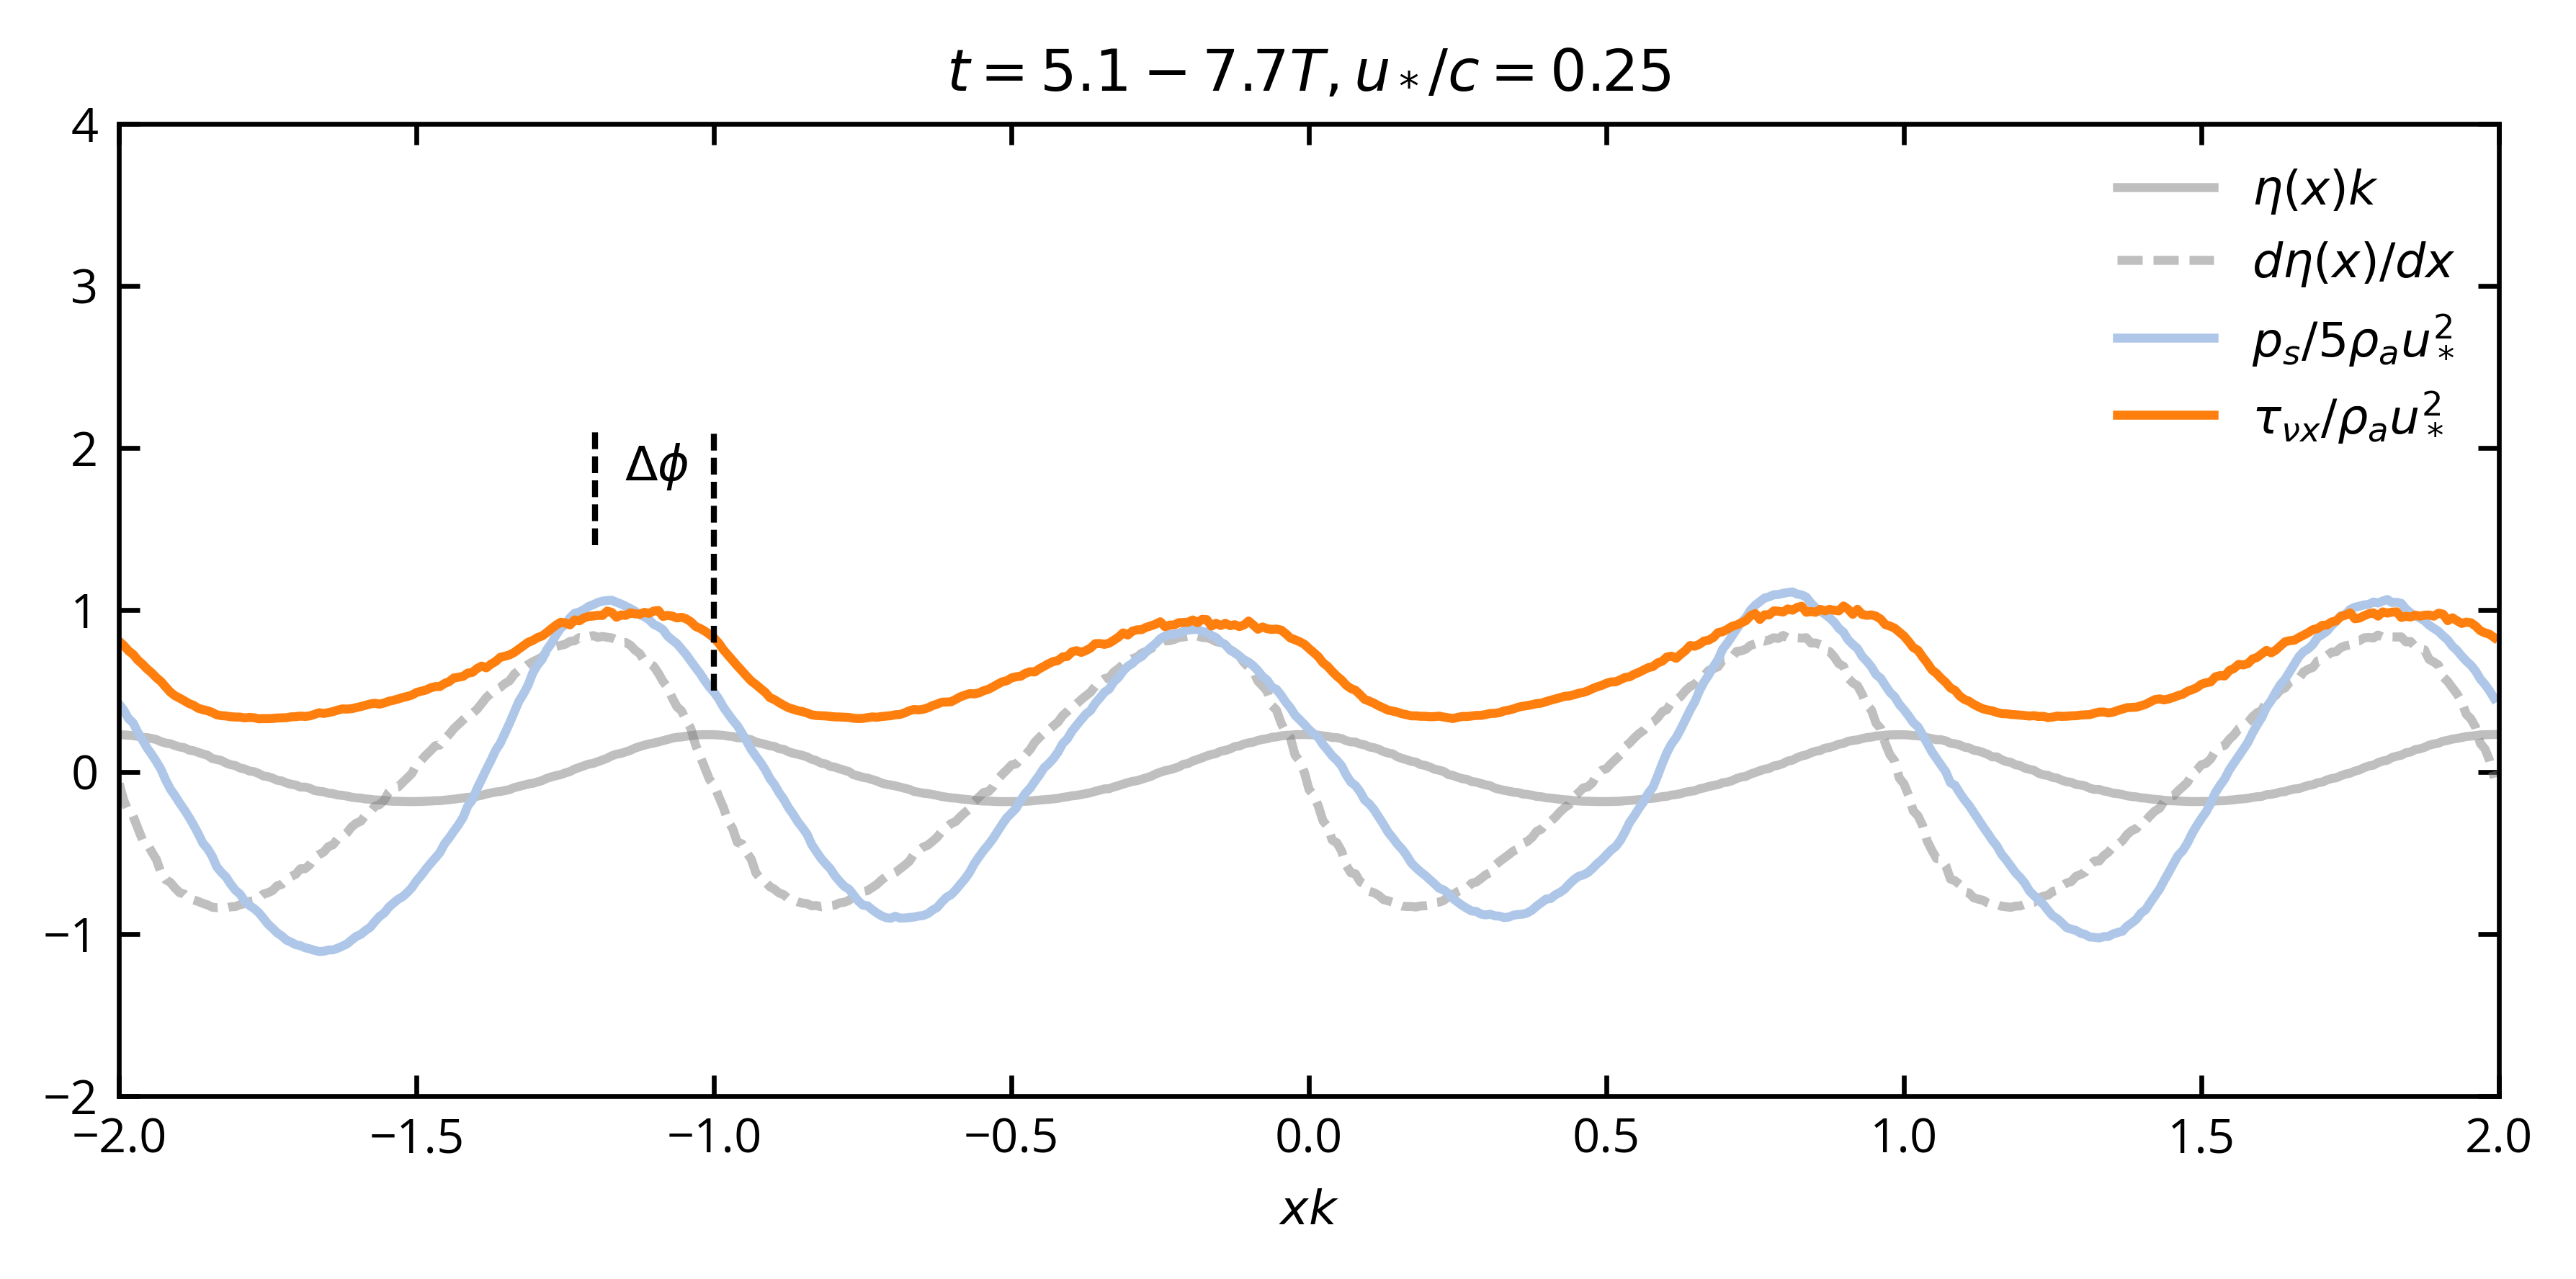

In [125]:
"""Visualization of averaged pressure and shear stress."""
fig = plt.figure(figsize=[6,3])
L0 = 2*np.pi; N =512
eta_1D_filtered = np.roll(np.average(interface.eta, axis=0), -(interface.idx), axis=0)
deta_dx = np.roll(np.average(interface.grad, axis=0), -(interface.idx), axis=0)
r1 = 0
r2 = 512
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), (eta_1D_filtered-1)[r1:r2]*4, alpha=0.5, label=r'$\eta(x)k $', color='gray')
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), deta_dx[r1:r2]*4, '--', alpha=0.5, label=r'$d\eta(x)/dx $', color='gray')
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), p1d_phase_aver[r1:r2]/5, label=r'$p_s/5\rho_{a}u_*^2$', color=plt.cm.tab20(1)) 
# plt.plot(interface.xarray/(2*np.pi/4), p1d_geo, label=r'$p_s(\partial \eta/ \partial x)/\rho_{a}u_*^2$', color=plt.cm.tab20(0)) 
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), tau1d_phase_aver[r1:r2], label=r'$\tau_{\nu x}/\rho_{a}u_*^2$', color=plt.cm.tab20(2))

"""Find the phase difference"""
# from scipy.signal import argrelextrema
# maxm1 = argrelextrema(p1d_phase_aver[r1:r2], np.greater)  # (array([1, 3, 6]),)
# maxm2 = argrelextrema(eta_1D_filtered[r1:r2], np.greater)  # (array([1, 3, 6]),)
# x1 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][5]])/(2*np.pi/4)
x1 = np.ones(20)*(-1.2)
y1= np.linspace(1.4,2.1,20)
plt.plot(x1,y1,'--', color='k',lw=1)
# x2 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][7]])/(2*np.pi/4)
x2 = np.ones(20)*(-1)
y2= np.linspace(0.5,2.1,20)
plt.plot(x2,y2,'--', color='k',lw=1)
plt.text(-1.15, 1.8, r'$\Delta\phi$')

plt.ylim([-2,4])
plt.xlim([-2,2])
# plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.legend(loc = 'upper right')
plt.xlabel(r'$xk$')
t = (np.array(case.t)-57)/(2*np.pi/case.wave.omega)
plt.title(r"$t=%.1f-%.1fT, u_*/c=%.2f$" %(t[0], t[-1], (case.ustar/case.wave.c)))

In [138]:
"""Write a moving window thing to compute the pressure forcing term and the growth rate (dE/dt directly not the exponential)"""
case = case2
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a
case.t = []
# Ensemble average of different time
p1d_phase_aver = []; tau1d_phase_aver = []
for j in tqdm(range (0,40,2)):
    p1d_shift_ensem = []; tau1d_shift_ensem = []
    t = 60 + j
    case.t.append(t)
    # Average over 5 time around the center t
    for i in range(t-2,t+3):
        interface = Interface2D(L0=2*np.pi, N=512, 
                                path=case.path, pre='eta/eta_loc_t', t=i, PRUNING=True)    
        interface.stress(tau0, mu_a)
        p1d = np.average(interface.p/tau0, axis=0)
        p1d_shift = np.roll(p1d, -(interface.idx), axis=0)
        p1d_shift_ensem.append(p1d_shift)
        tau1d = np.average(interface.tau_nux/tau0, axis=0)
        tau1d_shift = np.roll(tau1d, -(interface.idx), axis=0)
        tau1d_shift_ensem.append(tau1d_shift)
    p1d_phase_aver.append(np.average(p1d_shift_ensem, axis=0))
    tau1d_phase_aver.append(np.average(tau1d_shift_ensem, axis=0))

  0%|          | 0/20 [00:00<?, ?it/s]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
  5%|▌         | 1/20 [00:39<12:35, 39.77s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) 

FileNotFoundError: [Errno 2] No such file or directory: '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.2_MU8_LEVEL10_emax0.3/eta/eta_loc_t100'

Text(0.5, 1.0, '$t=1.9-26.2T, u_*/c=0.25$')

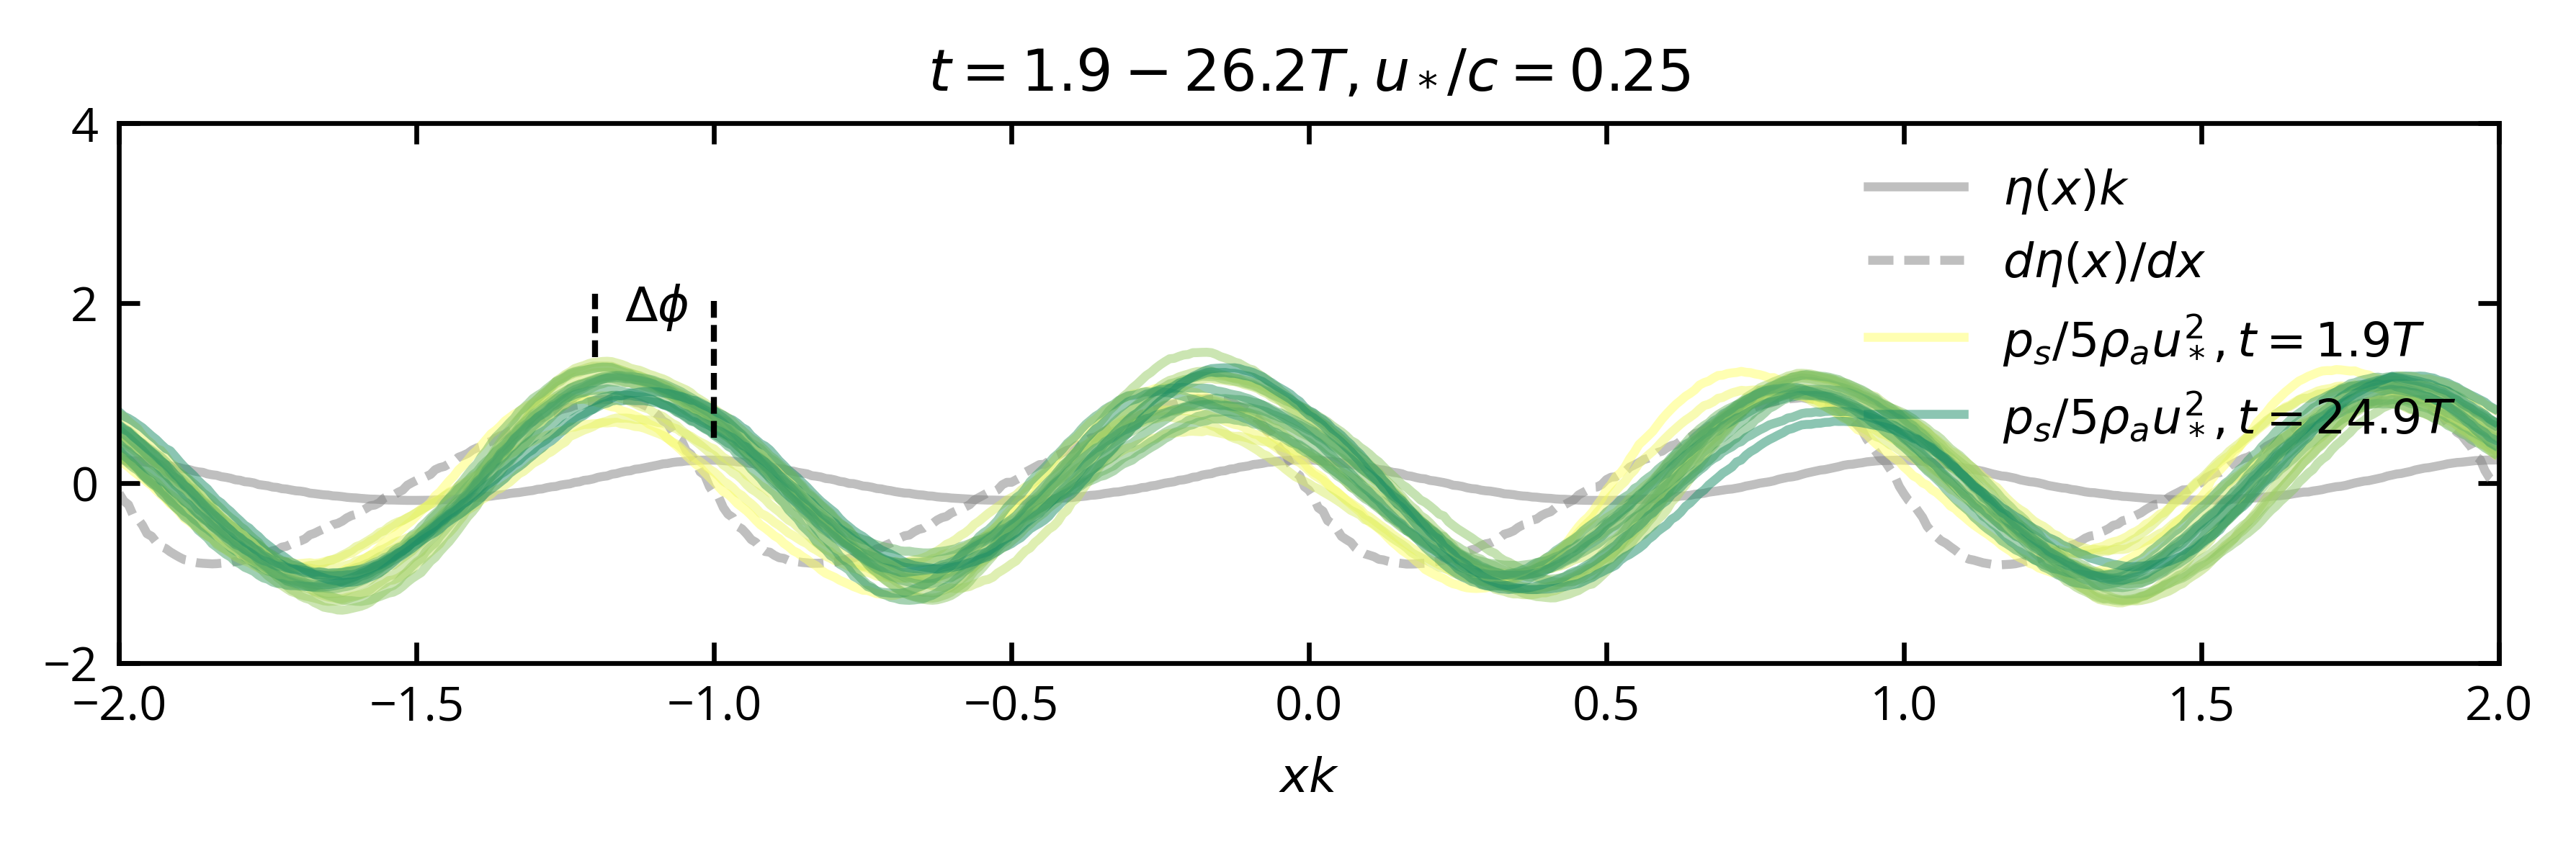

In [155]:
fig = plt.figure(figsize=[6,2])
L0 = 2*np.pi; N =512
eta_1D_filtered = np.roll(np.average(interface.eta, axis=0), -(interface.idx), axis=0)
deta_dx = np.roll(np.average(interface.grad, axis=0), -(interface.idx), axis=0)
r1 = 0
r2 = 512
case.tstart = 57

plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), (eta_1D_filtered-1)[r1:r2]*4, alpha=0.5, label=r'$\eta(x)k $', color='gray')
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), deta_dx[r1:r2]*4, '--', alpha=0.5, label=r'$d\eta(x)/dx $', color='gray')
for (i,p1d) in enumerate(p1d_phase_aver):
    if i == 0 or i == 18:
        plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), p1d[r1:r2]/5, label=r'$p_s/5\rho_{a}u_*^2, t = %.1fT$' %((case.t[i]-case.tstart)*case.wave.omega/(2*np.pi)), 
                 color=plt.cm.get_cmap('summer')(1-i/20), alpha = 0.5)
    else:
        plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), p1d[r1:r2]/5,
                 color=plt.cm.get_cmap('summer')(1-i/20), alpha = 0.5) 
# for (i,tau1d) in enumerate(tau1d_phase_aver):
#     plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), tau1d[r1:r2], label=r'$\tau_{\nu x}/\rho_{a}u_*^2$', color=plt.cm.get_cmap('summer')(1-i/5))

"""Find the phase difference"""
# from scipy.signal import argrelextrema
# maxm1 = argrelextrema(p1d_phase_aver[r1:r2], np.greater)  # (array([1, 3, 6]),)
# maxm2 = argrelextrema(eta_1D_filtered[r1:r2], np.greater)  # (array([1, 3, 6]),)
# x1 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][5]])/(2*np.pi/4)
x1 = np.ones(20)*(-1.2)
y1= np.linspace(1.4,2.1,20)
plt.plot(x1,y1,'--', color='k',lw=1)
# x2 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][7]])/(2*np.pi/4)
x2 = np.ones(20)*(-1)
y2= np.linspace(0.5,2.1,20)
plt.plot(x2,y2,'--', color='k',lw=1)
plt.text(-1.15, 1.8, r'$\Delta\phi$')

plt.ylim([-2,4])
plt.xlim([-2,2])
# plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.legend(loc = 'upper right')
plt.xlabel(r'$xk$')
t = (np.array(case.t)-57)/(2*np.pi/case.wave.omega)
plt.title(r"$t=%.1f-%.1fT, u_*/c=%.2f$" %(t[0], t[-1], (case.ustar/case.wave.c)))

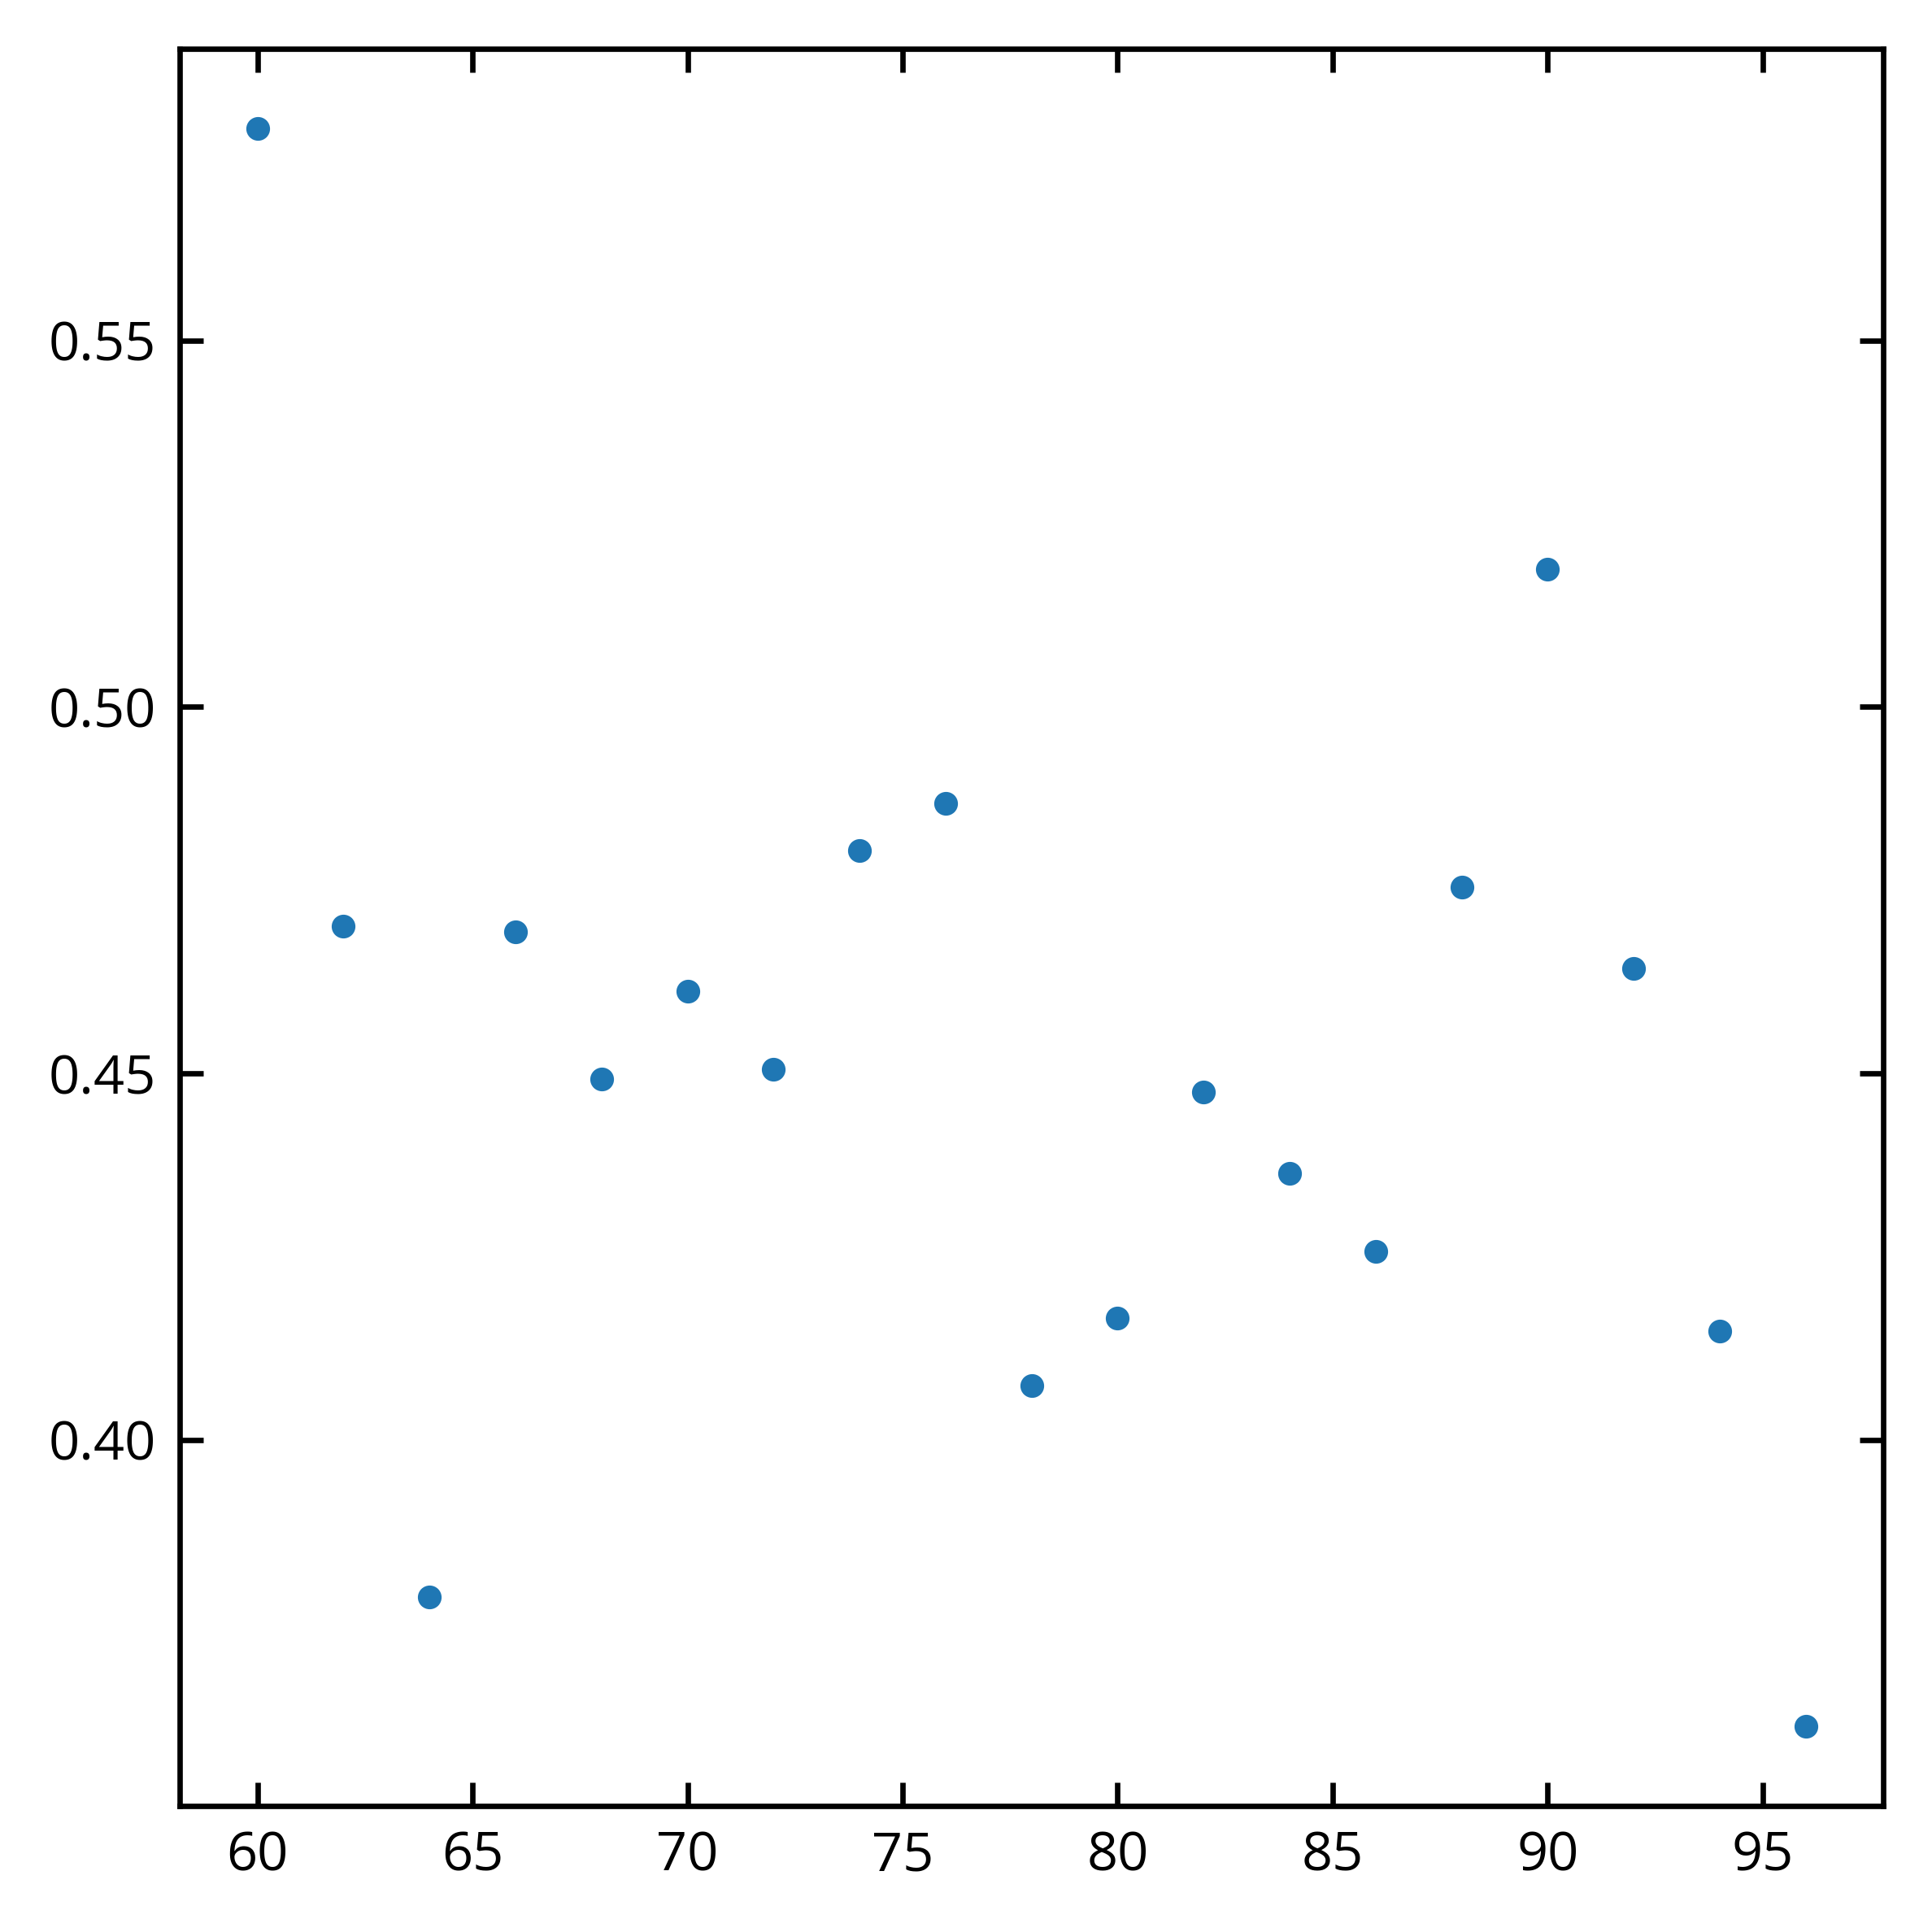

In [142]:
p1d_phase_aver = np.array(p1d_phase_aver)
tau1d_phase_aver = np.array(tau1d_phase_aver)
Fp = []
for p1d in p1d_phase_aver:
    Fp.append(np.average(p1d[r1:r2]*deta_dx[r1:r2]))
plt.plot(case.t[0:-1], Fp, '.')

In [126]:
"""Verify the pressure forcing theory"""
Fp = np.average(p1d_phase_aver[r1:r2]*deta_dx[r1:r2])
print(Fp)
beta_fromp = 2*np.pi*1/850*(0.25)**2*2*Fp/0.2**2
print(beta_fromp)
# beta = T/E*(dE/dt) = 0.037/0.008

0.42739513570466536
0.009872804547866097


In [115]:
Fp = np.average(p1d_phase_aver[r1:r2]*deta_dx[r1:r2])
print(Fp)
beta_fromp = 2*np.pi*1/850*(0.5)**2*2*Fp/0.2**2
print(beta_fromp)
# beta = T/E*(dE/dt) = 0.037/0.008

0.42990575250625696
0.03972319864146025


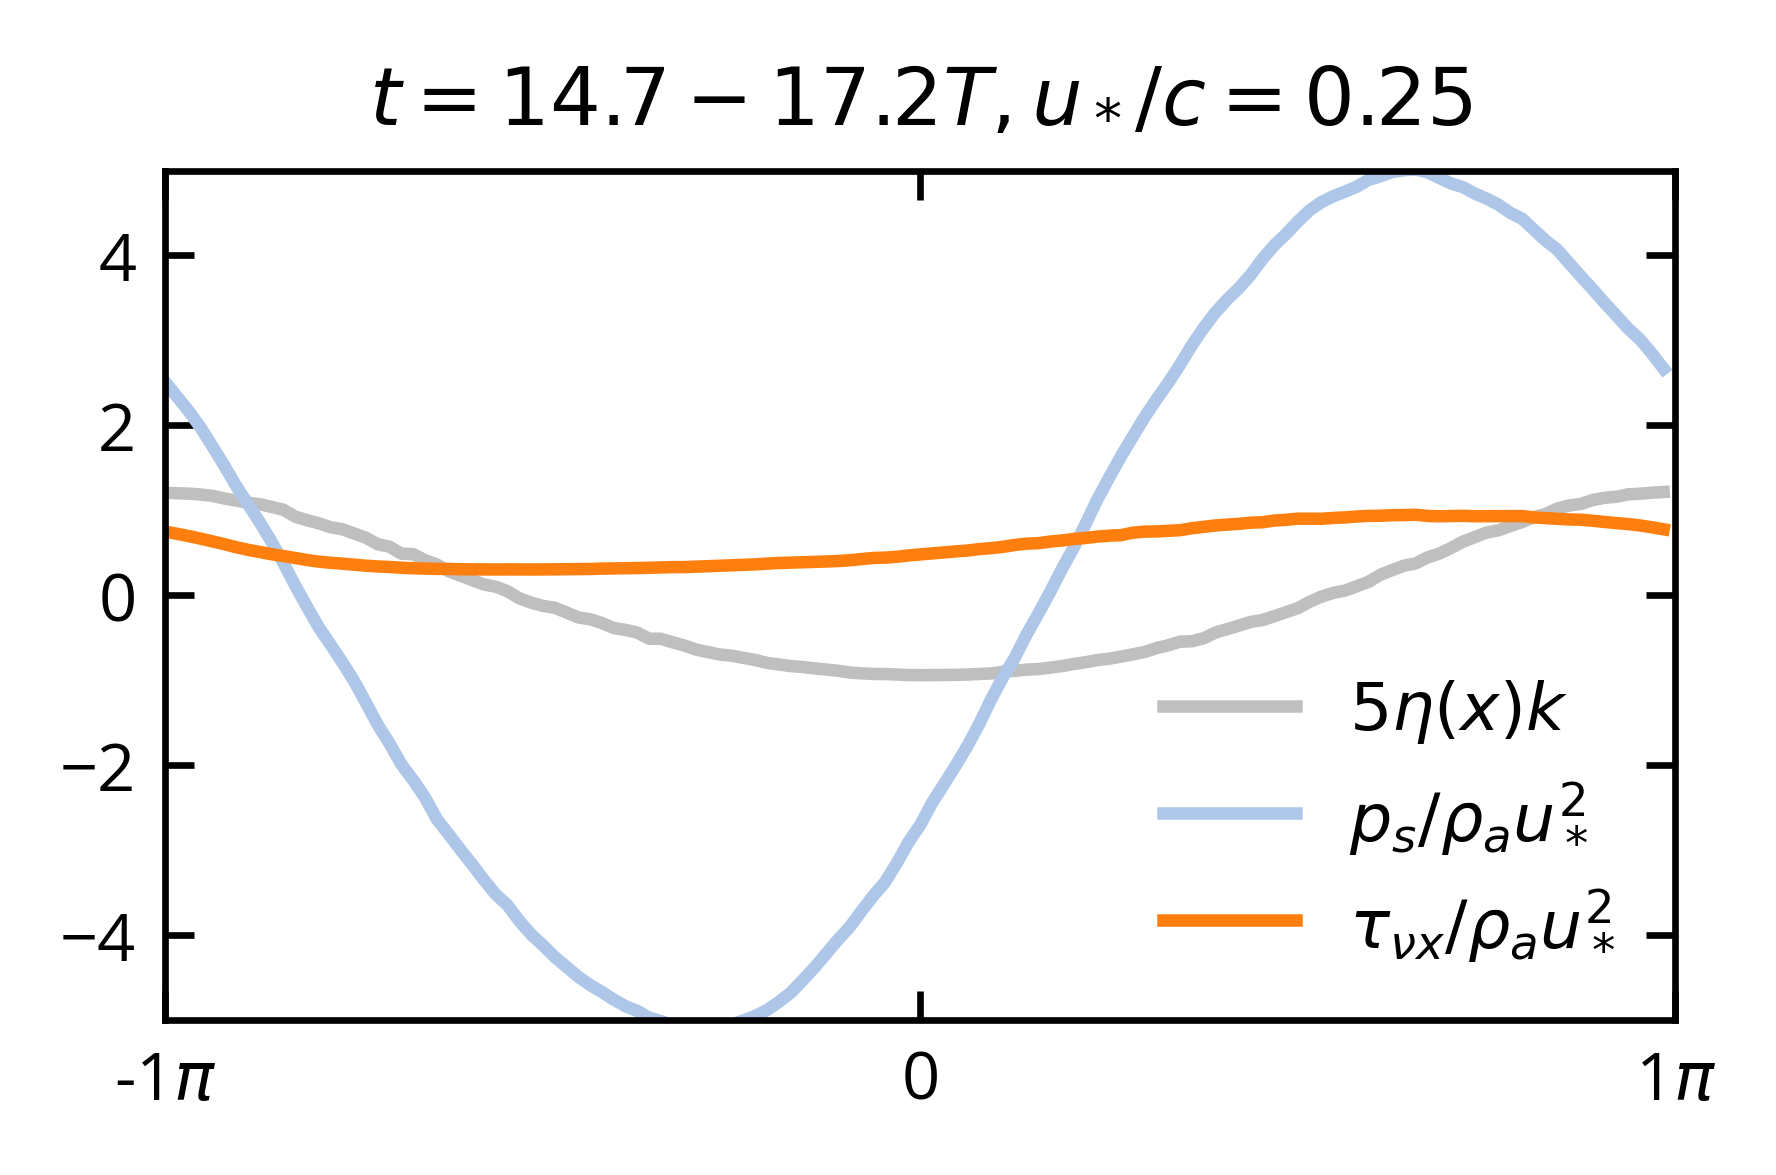

In [9]:
"""Additional averaging between the four crest"""
plt.figure(figsize=[3,2]); ax =plt.gca()
p1d_split = (p1d_phase_aver[0:128], p1d_phase_aver[128:256], p1d_phase_aver[256:384], p1d_phase_aver[384:512])
p1d_phase_aver_1 = np.average(p1d_split, axis=0)
tau1d_split = (tau1d_phase_aver[0:128], tau1d_phase_aver[128:256], tau1d_phase_aver[256:384], tau1d_phase_aver[384:512])
tau1d_phase_aver_1 = np.average(tau1d_split, axis=0)
plt.plot(interface.xarray[192:320]*4, (eta_1D_filtered-1)[0:128]*4*5, alpha=0.5, label=r'$5\eta(x)k $', color='gray')
plt.plot(interface.xarray[192:320]*4, p1d_phase_aver_1, label=r'$p_s/\rho_{a}u_*^2$', color=plt.cm.tab20(1))
plt.plot(interface.xarray[192:320]*4, tau1d_phase_aver_1, label=r'$\tau_{\nu x}/\rho_{a}u_*^2$', color=plt.cm.tab20(2)) 
plt.title(r"$t=%.1f-%.1fT, u_*/c=%.2f$" %(t[0], t[-1], (case.ustar/case.wave.c)))
plt.ylim([-5,5])
plt.xlim([-np.pi,np.pi])
plt.legend(loc='lower right')
from matplotlib.ticker import FuncFormatter, MultipleLocator
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))

'TODO: add stress from the bulk flow'

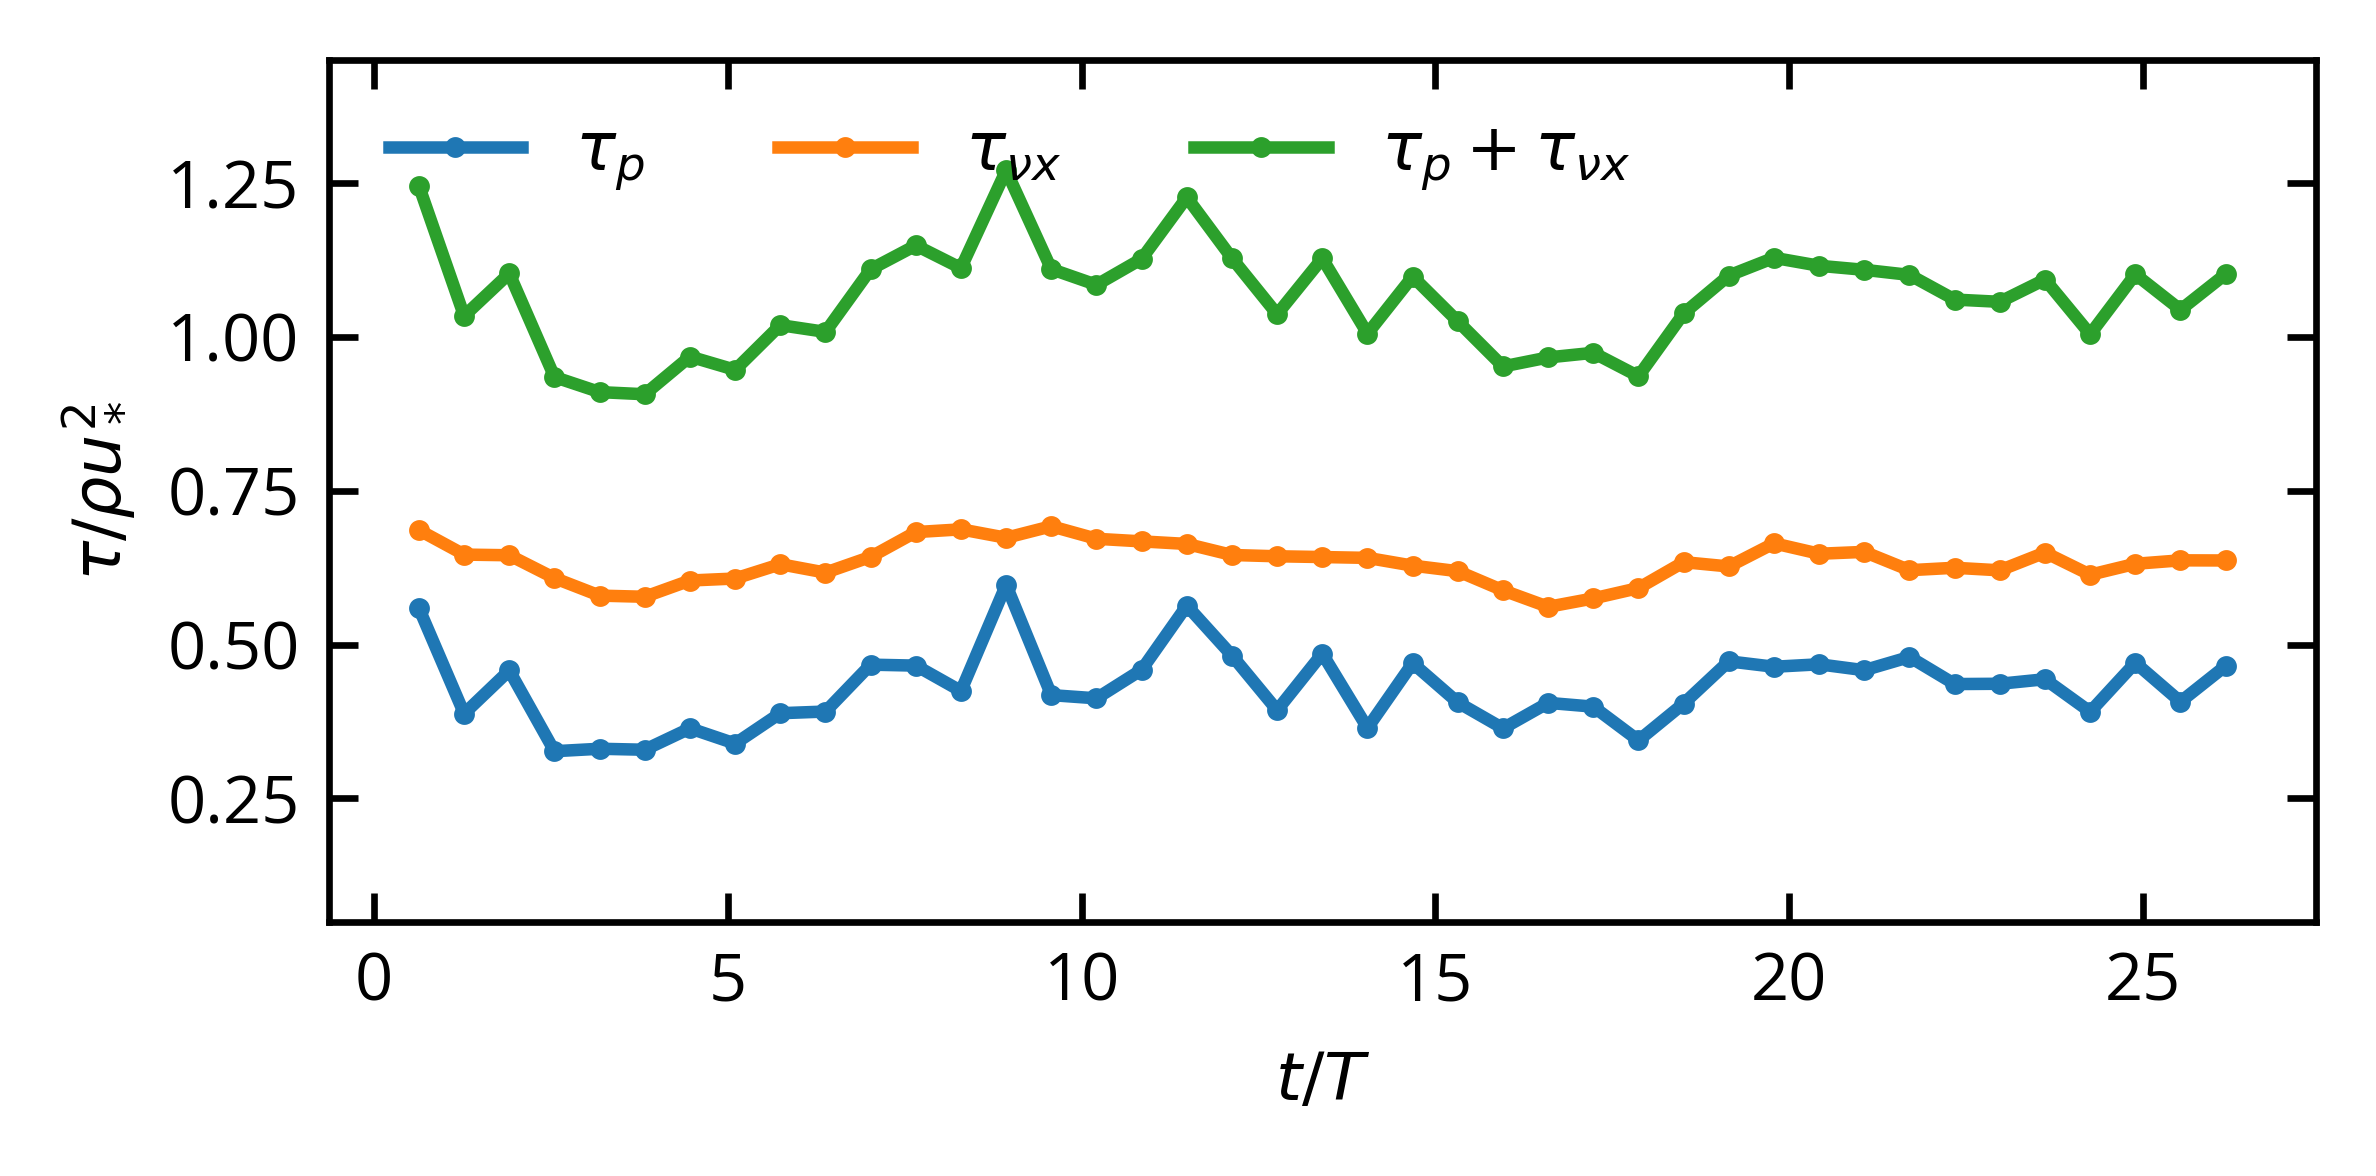

In [76]:
fig = plt.figure(figsize=[4,2])
t = np.arange(1,42)
case = case2
T = 2*np.pi/case.wave.omega 
formdrag = np.array(case.formdrag); shear = np.array(case.shear)
plt.plot(t/T, formdrag/tau0, label = r'$\tau_p$', marker='.', markersize=3)
plt.plot(t/T, shear/tau0, label = r'$\tau_{\nu x}$', marker='.', markersize=3)
plt.plot(t/T, (shear+formdrag)/tau0, label = r'$\tau_p + \tau_{\nu x}$', marker='.', markersize=3)
plt.xlabel(r'$t/T$'); plt.ylabel(r'$\tau/\rho u_*^2$')
plt.ylim([0.05,1.45])
plt.legend(loc='upper left', ncol=3)
fig.savefig('/home/jiarong/Downloads/ICTAM/stress_partition_g4.pdf')
"""TODO: add stress from the bulk flow"""

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(interface.xdata, interface.zdata, interface.pdata-np.average(interface.pdata), c=interface.pdata, cmap='Greens')

0.3209327550488652 0.5828758052076489


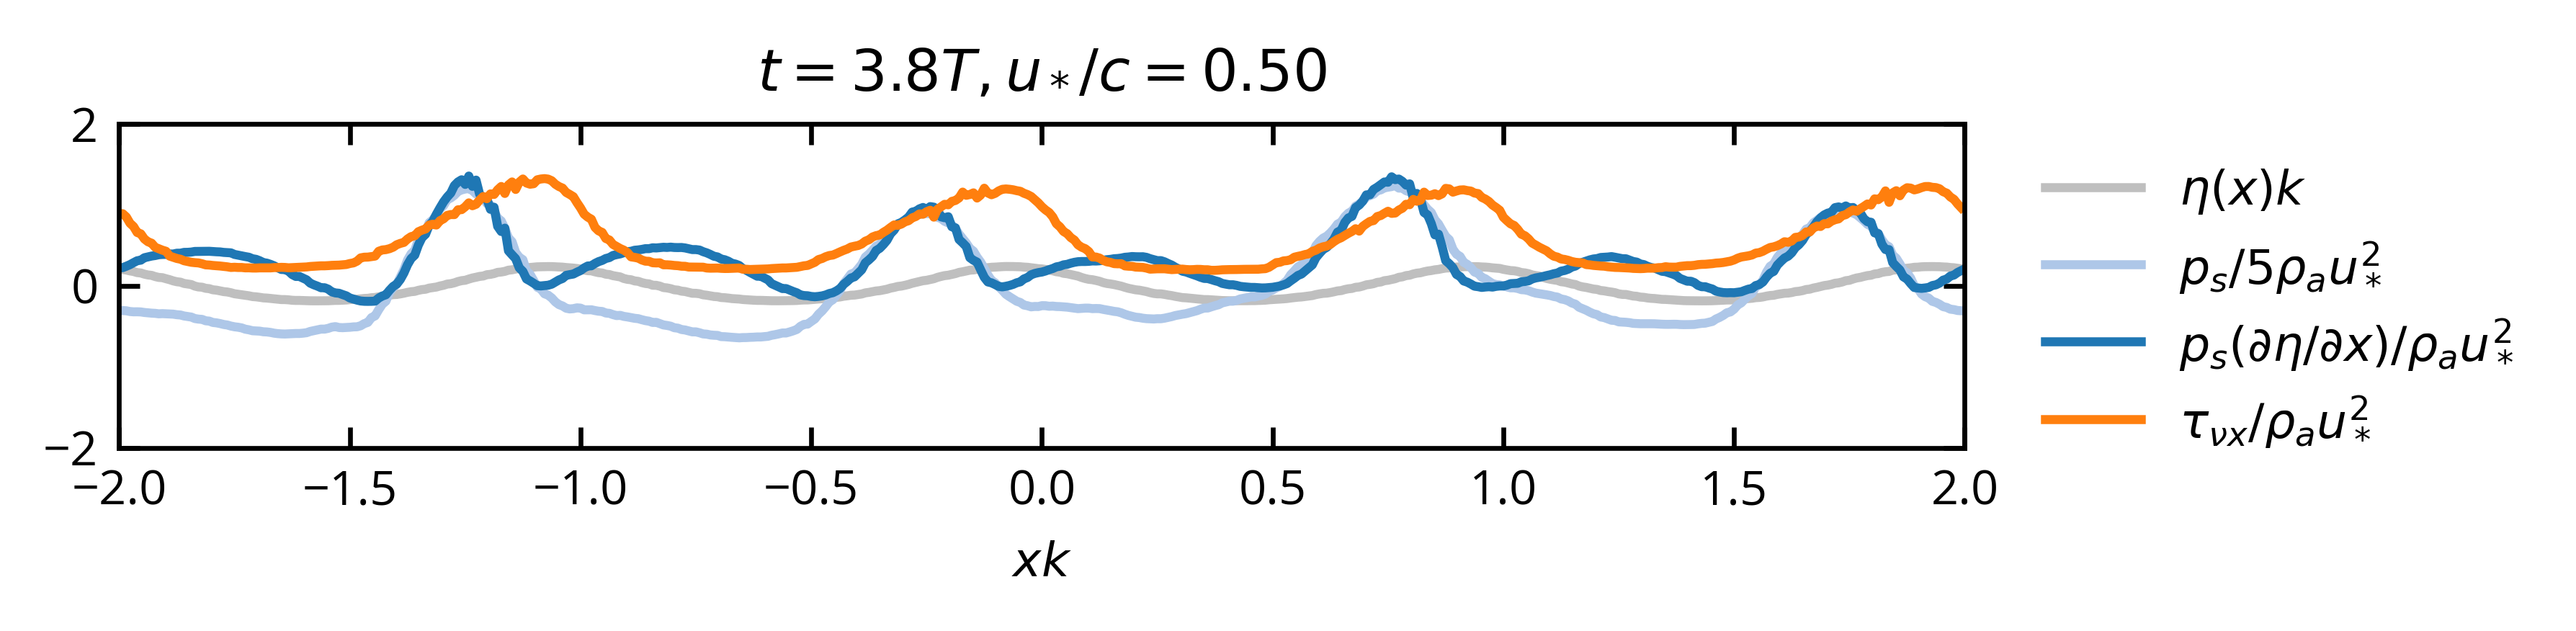

In [18]:
"""Comparison of 1D averaged stress between two methods.
Comes after the stress function was called."""

fig = plt.figure(figsize=[6,1.5])
t = 69
case = case1
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a
interface = Interface2D(L0 = 2*np.pi, N = 512, 
                        path = case.path, 
                        pre='eta/eta_loc_t', t = t, PRUNING=True)
interface.stress(tau0, mu_a)

L0 = 2*np.pi; N =512
eta_1D_filtered = np.average(interface.eta, axis=0)
plt.plot(interface.xarray/(2*np.pi/4), (eta_1D_filtered-1)*4, alpha = 0.5, label=r'$\eta(x)k $', color = 'gray')
# plt.plot(interface.xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', alpha = 0.5, label=r'$10d\eta/dx$', color = 'gray')

# Method 1 bulk interpolation
# plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[3][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2), 
#          label = r'$p_s/\rho_{a}u_*^2$ method 1', color = plt.cm.tab20(0))
# plt.plot(xarray[0:-1]/(2*np.pi/4), 5.*(tauv_dudy[1][0:-1])*nu_a/0.25**2, 
#          label = r'$5\tau_{\nu}/\rho_{a}u_*^2$ method 1', color = plt.cm.tab20(2))

# Method 2 probing interface
p1d = np.average(interface.p/tau0, axis = 0)
p1d_geo = np.average(interface.p*interface.grad/tau0, axis = 0)
tau1d = np.average(interface.tau_nux/tau0, axis = 0)
plt.plot(interface.xarray/(2*np.pi/4), p1d/5, label=r'$p_s/5\rho_{a}u_*^2$', color = plt.cm.tab20(1)) 
plt.plot(interface.xarray/(2*np.pi/4), p1d_geo, label=r'$p_s(\partial \eta/ \partial x)/\rho_{a}u_*^2$', color = plt.cm.tab20(0)) 
plt.plot(interface.xarray/(2*np.pi/4), tau1d, label=r'$\tau_{\nu x}/\rho_{a}u_*^2$', color = plt.cm.tab20(2))
# plt.plot(xarray/(2*np.pi/4), 5.*tau1d_extra, '--', label=r'$5\tau_{\nu}/\rho_{a}u_*^2$ method 2', color = plt.cm.tab20(3))

plt.ylim([-2,2])
plt.xlim([-2,2])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.xlabel(r'$xk$')
# plt.title(r"$t=%g, u_*/c=%g$" %(60-57, 0.25))
plt.title(r"$t=%.1fT, u_*/c=%.2f$" %((t-57)/(2*np.pi/case.wave.omega), (case.ustar/case.wave.c)))
print(interface.formdrag/tau0, interface.shear/tau0)
fig.savefig('/home/jiarong/Downloads/ICTAM/stress_alongx_g1_t12.pdf')
# fig.savefig('/home/jiarong/Downloads/ICTAM/stress_alongx_g4_t6.pdf')

0.037247013104251346
0.007640026456699297


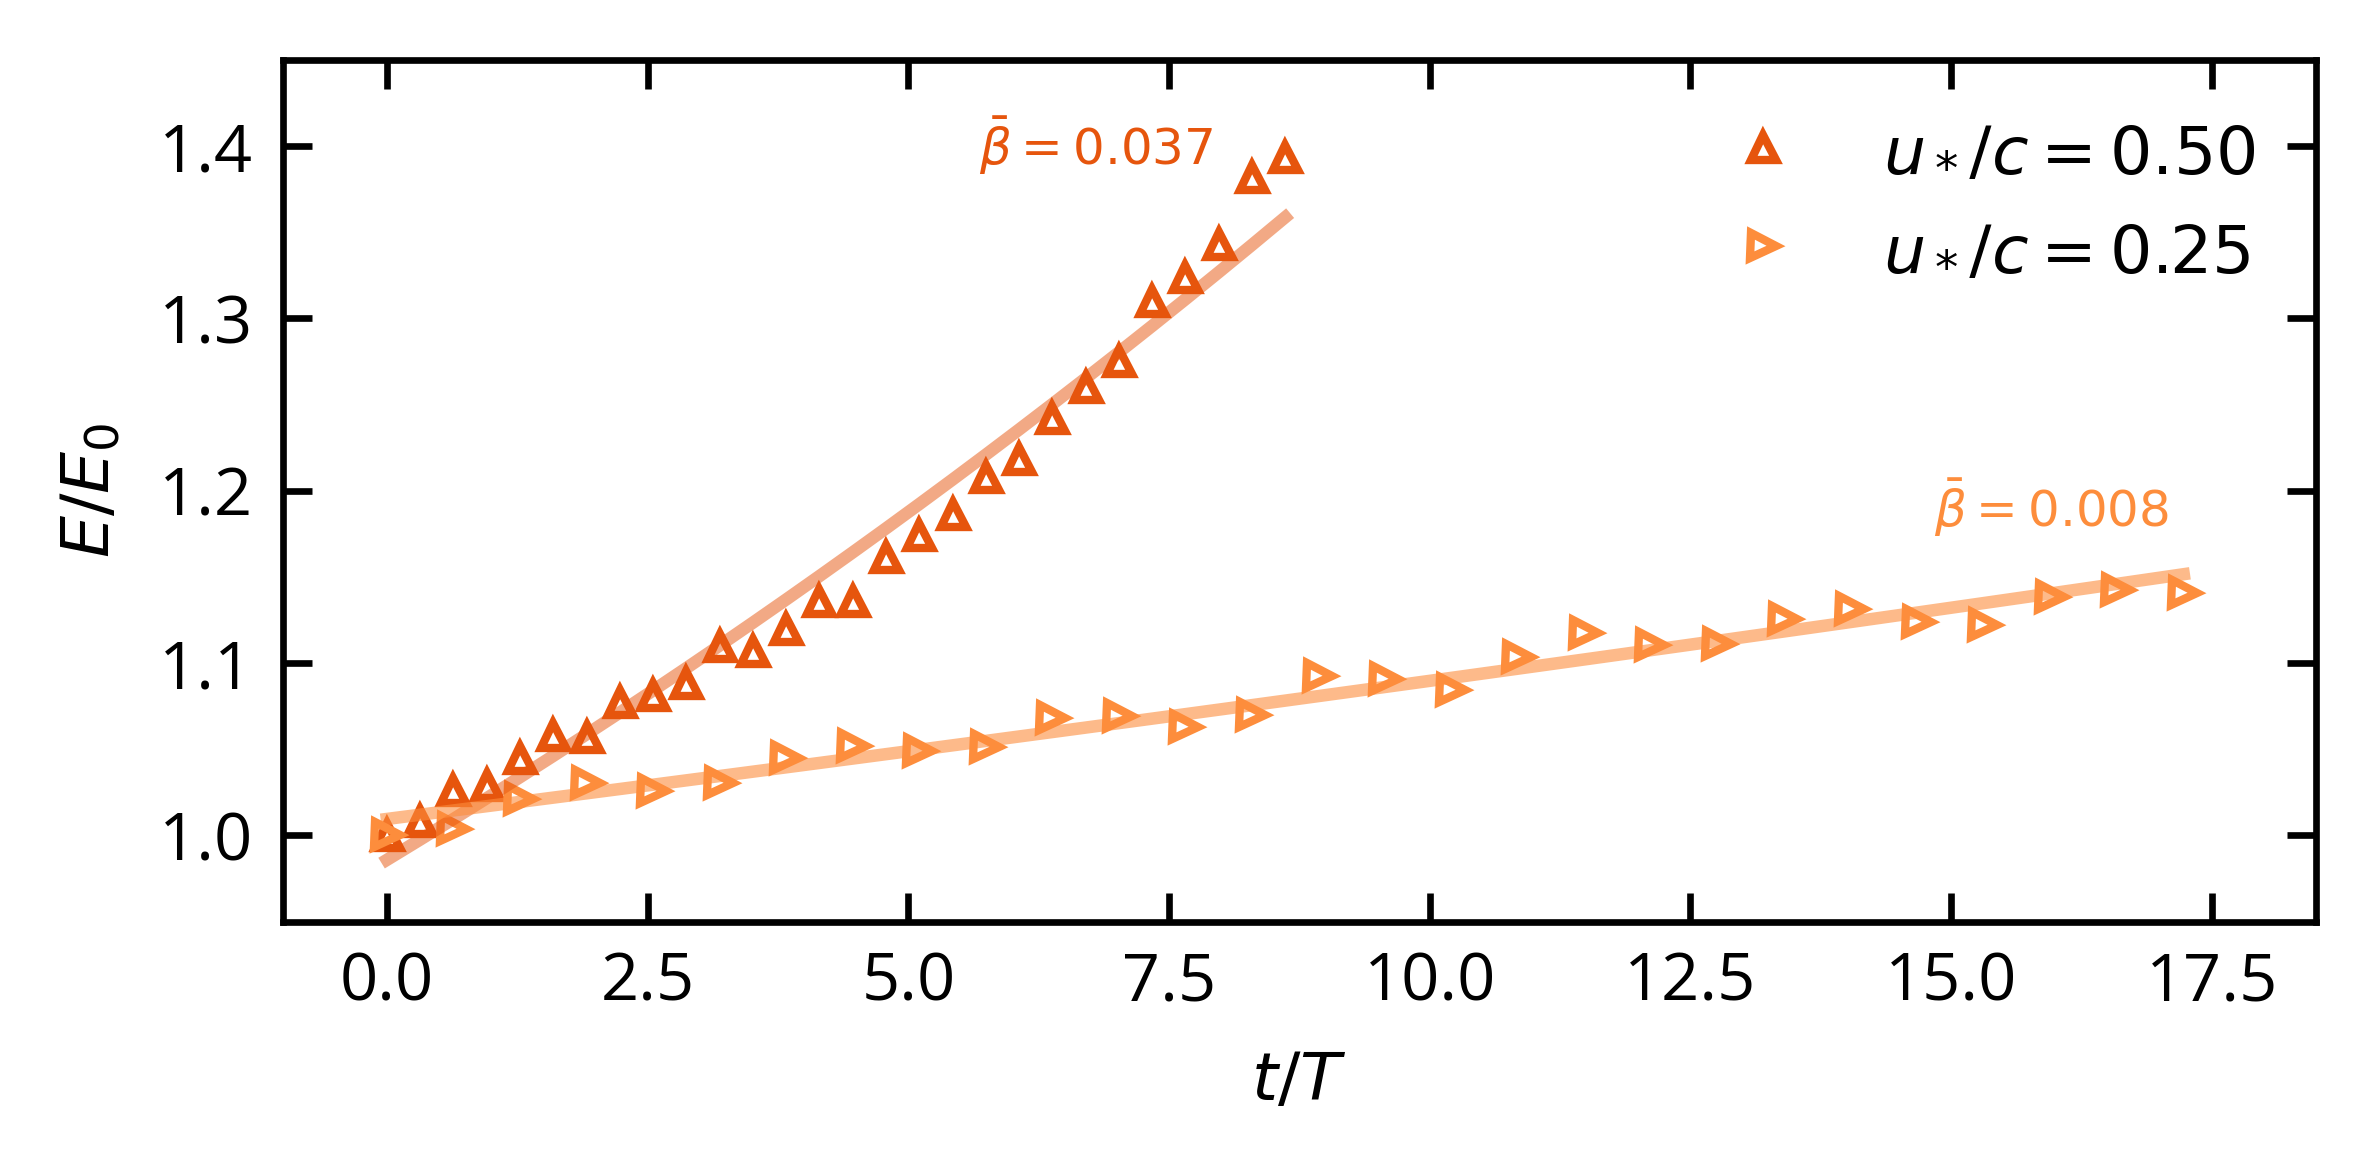

In [228]:
"""Wave growth"""
'''Energy plot'''
fig = plt.figure(figsize=[4,2]); ax = plt.gca()

t_spectrum = np.array(t_spectrum) # t_spectrum is from 2d fft

"""Plot the rms eta or the Fp"""
case = case1
imax = 60
T = 2*np.pi/case.wave.omega 
# plt.plot(np.array(case.t[0:imax:2])/T, np.array(case.energy[0:imax:2])/case.energy[0], marker = '.',
#          label = r'$u_*/c=%.2f$' %(case.ustar/case.wave.c), lw=1, markersize=3,
#          color=plt.get_cmap('tab20c')(4)) 
plt.plot(t_spectrum/T, case.Fp/case.Fp[0], color=plt.get_cmap('tab20c')(4), marker = '^', mfc='none',
         markeredgewidth=1, lw=0, markersize=3, label = r'$u_*/c=%.2f$' %(case.ustar/case.wave.c))

case = case2
imax = 30
T = 2*np.pi/case.wave.omega 
# plt.plot(np.array(case.t[0:imax])/T, np.array(case.energy[0:imax])/case.energy[0], marker = '.',
#          label = r'$u_*/c=%.2f$' %(case.ustar/case.wave.c), lw=1, markersize=3,
#          color=plt.get_cmap('tab20c')(5)) 
plt.plot(t_spectrum/T, case.Fp/case.Fp[0], color=plt.get_cmap('tab20c')(5), marker = '>', mfc='none',
         markeredgewidth=1, lw=0, markersize=3, label = r'$u_*/c=%.2f$' %(case.ustar/case.wave.c))

"""Fit an exponential"""
T = 2*np.pi/case1.wave.omega
case1.wa, wb = np.polyfit(t_spectrum/T, np.log(case1.Fp/case1.Fp[0]), 1)
plt.plot(t_spectrum/T, np.exp(case1.wa*t_spectrum/T+wb), color=plt.get_cmap('tab20c')(4), alpha = 0.5)
print(case1.wa)
T = 2*np.pi/case2.wave.omega
case2.wa, wb = np.polyfit(t_spectrum/T, np.log(case2.Fp/case2.Fp[0]), 1)
plt.plot(t_spectrum/T, np.exp(case2.wa*t_spectrum/T+wb), color=plt.get_cmap('tab20c')(5), alpha = 0.6)
print(case2.wa)

ax.text(0.4, 0.9, r'$\bar{\beta} = %.3f$' % case1.wa, ha='center', va='center', rotation=0., fontsize=6, 
        color=plt.get_cmap('tab20c')(4), transform=ax.transAxes)
ax.text(0.87, 0.48, r'$\bar{\beta} = %.3f$' % case2.wa, ha='center', va='center', rotation=0., fontsize=6, 
        color=plt.get_cmap('tab20c')(5), transform=ax.transAxes)
plt.xlabel(r'$t/T$'); plt.ylabel(r'$E/E_0$'); plt.ylim([0.95,1.45]); plt.xlim([-1,18.5])
plt.legend(loc='upper right')
fig.savefig('/home/jiarong/Downloads/ICTAM/wavegrowth_Fp.pdf')

In [227]:
0.0076*850/(2*np.pi)*16

16.450254917978302

In [226]:
0.037*850/(2*np.pi)*4

20.021691840960433

 89%|████████▉ | 25/28 [02:54<00:21,  7.07s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
 93%|█████████▎| 26/28 [03:01<00:14,  7.12s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 28/28 [03:16<00:00,  7.02s/it]


In [142]:
case = case2
case.Fp = []
t_spectrum = [] # Sampling time for the 2D spectrum
for i in tqdm(range(1,29)):
    N = 512; L = 2*np.pi
    t_spectrum.append(i)
    t = 57 + i
    interface = Interface2D(L0 = L, N = N, 
                            path = case.path, pre='eta/eta_loc_t', t = t, PRUNING=True)
    spectrum = np.fft.fft2(interface.eta-np.average(interface.eta))*(1/N)**2 # How to normalize here?!
    F = np.absolute(spectrum)
    case.Fp.append(np.average(F,axis=0)[4]) # Only record the peak frequency spetrum amplitude

  0%|          | 0/28 [00:00<?, ?it/s]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
 11%|█         | 3/28 [00:22<03:07,  7.48s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
 21%|██▏       | 6/28 [00:45<02:46,  7.55s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
 25%|██▌       | 7/28 [00:53<02:38,  7.56s/it]/home/jiarong/anaconda3/lib/python3.8/sit

In [73]:
print(np.sum(p1d*eta_1D_grad_filtered)/512)
print(np.sum(tau1d)/512)
print(np.sum(tau1d/(1+eta_1D_grad_filtered**2)**0.5)/512)

0.35447135412111264
0.5383250039031262
0.5319353307806725


In [106]:
p1d = (pinterp[3][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2)
tau1d = tauv_dudy[1]*nu_a/0.25**2
print(np.sum(p1d*eta_1D_grad_filtered[0:-1])/512)
print(np.sum(tau1d)/512)

0.47501048187998995
0.5219005011710582


In [85]:
interface = Interface2D(L0 = 2*np.pi, N = 512, 
                        path = case_pre1.path, 
                        pre='eta/eta_loc_t', t = 76, PRUNING=True)
tau0 = case1.ustar**2*case1.rho2
L0 = case1.L0
interface.stress(tau0, case1.mu2)

In [40]:
"""How to draw coordinate arrow
https://stackoverflow.com/questions/57015852/is-there-a-way-to-plot-a-3d-cartesian-coordinate-system-with-matplotlib/57790156"""
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)


def cuboid_data(center, size):
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = np.array([[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]])  # x coordinate of points in inside surface
    y = np.array([[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]])    # y coordinate of points in inside surface
    z = np.array([[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]])                # z coordinate of points in inside surface
    return x, y, z


# if __name__ == '__main__':
#     center = [0, 0, 0]
#     length = 1
#     width = 1
#     height = 1
#     fig = plt.figure()
#     ax1 = fig.add_subplot(111, projection='3d')
#     X, Y, Z = cuboid_data(center, (length, width, height))
#     ax1.plot_surface(X, Y, Z, color='b', rstride=1, cstride=1, alpha=0.1)
#     ax1.set_xlabel('X')
#     ax1.set_xlim(-1, 1)
#     ax1.set_ylabel('Y')
#     ax1.set_ylim(-1, 1)
#     ax1.set_zlabel('Z')
#     ax1.set_zlim(-1, 1)

#     # Here we create the arrows:
#     arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)

#     a = Arrow3D([0, 1], [0, 0], [0, 0], **arrow_prop_dict, color='r')
#     ax1.add_artist(a)
#     a = Arrow3D([0, 0], [0, 1], [0, 0], **arrow_prop_dict, color='b')
#     ax1.add_artist(a)
#     a = Arrow3D([0, 0], [0, 0], [0, 1], **arrow_prop_dict, color='g')
#     ax1.add_artist(a)

#     # Give them a name:
#     ax1.text(0.0, 0.0, -0.1, r'$0$')
#     ax1.text(1.1, 0, 0, r'$x$')
#     ax1.text(0, 1.1, 0, r'$y$')
#     ax1.text(0, 0, 1.1, r'$z$')

#     plt.show()

In [ ]:
"""3D imshow with plot_surface"""
fig = plt.figure(figsize=[4,4]); ax = plt.gca(projection='3d')
xx, yy = np.meshgrid(interface.xarray, interface.xarray)

X =  xx 
Y =  yy
Z =  interface.eta

data = (interface.p)/tau0
# Range of colormap is (0,1) so need to renormalize data
ax.plot_surface(X, Y, Z, rstride=4, cstride=4, facecolors=plt.cm.RdBu((1-data/15)/2), shade=False)
ax.set_axis_off()
ax.set_zlim([0,2*np.pi]); ax.set_xlim([-np.pi,np.pi]); ax.set_ylim([-np.pi,np.pi])

"""Draw a simple line"""
xp = interface.xarray; yp = np.ones(512)*(-np.pi-0.05); zp = np.average(interface.eta, axis=0)
ax.plot(xp, yp, zp, c='gray')
ax.plot(xp, yp+(2*np.pi+0.1), zp, c='gray')

"""Here we create the arrows:"""
arrow_prop_dict = dict(mutation_scale=10, arrowstyle='->', shrinkA=0, shrinkB=0)

a = Arrow3D([-3,-2], [-4, -4], [1, 1], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D([-3, -3], [-4, -5], [1, 1], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D([-3, -3], [-4, -4], [1, 2], **arrow_prop_dict, color='k')
ax.add_artist(a)
# ax.text(0.0, 0.0, -0.1, r'$0$')
ax.text(-1.9, -4, 1, r'$x$')
ax.text(-3, -5.4, 1, r'$z$')
ax.text(-3, -4, 2.1, r'$y$')
fig.savefig('/home/jiarong/Downloads/ResearchDay/pressure_camera.pdf')

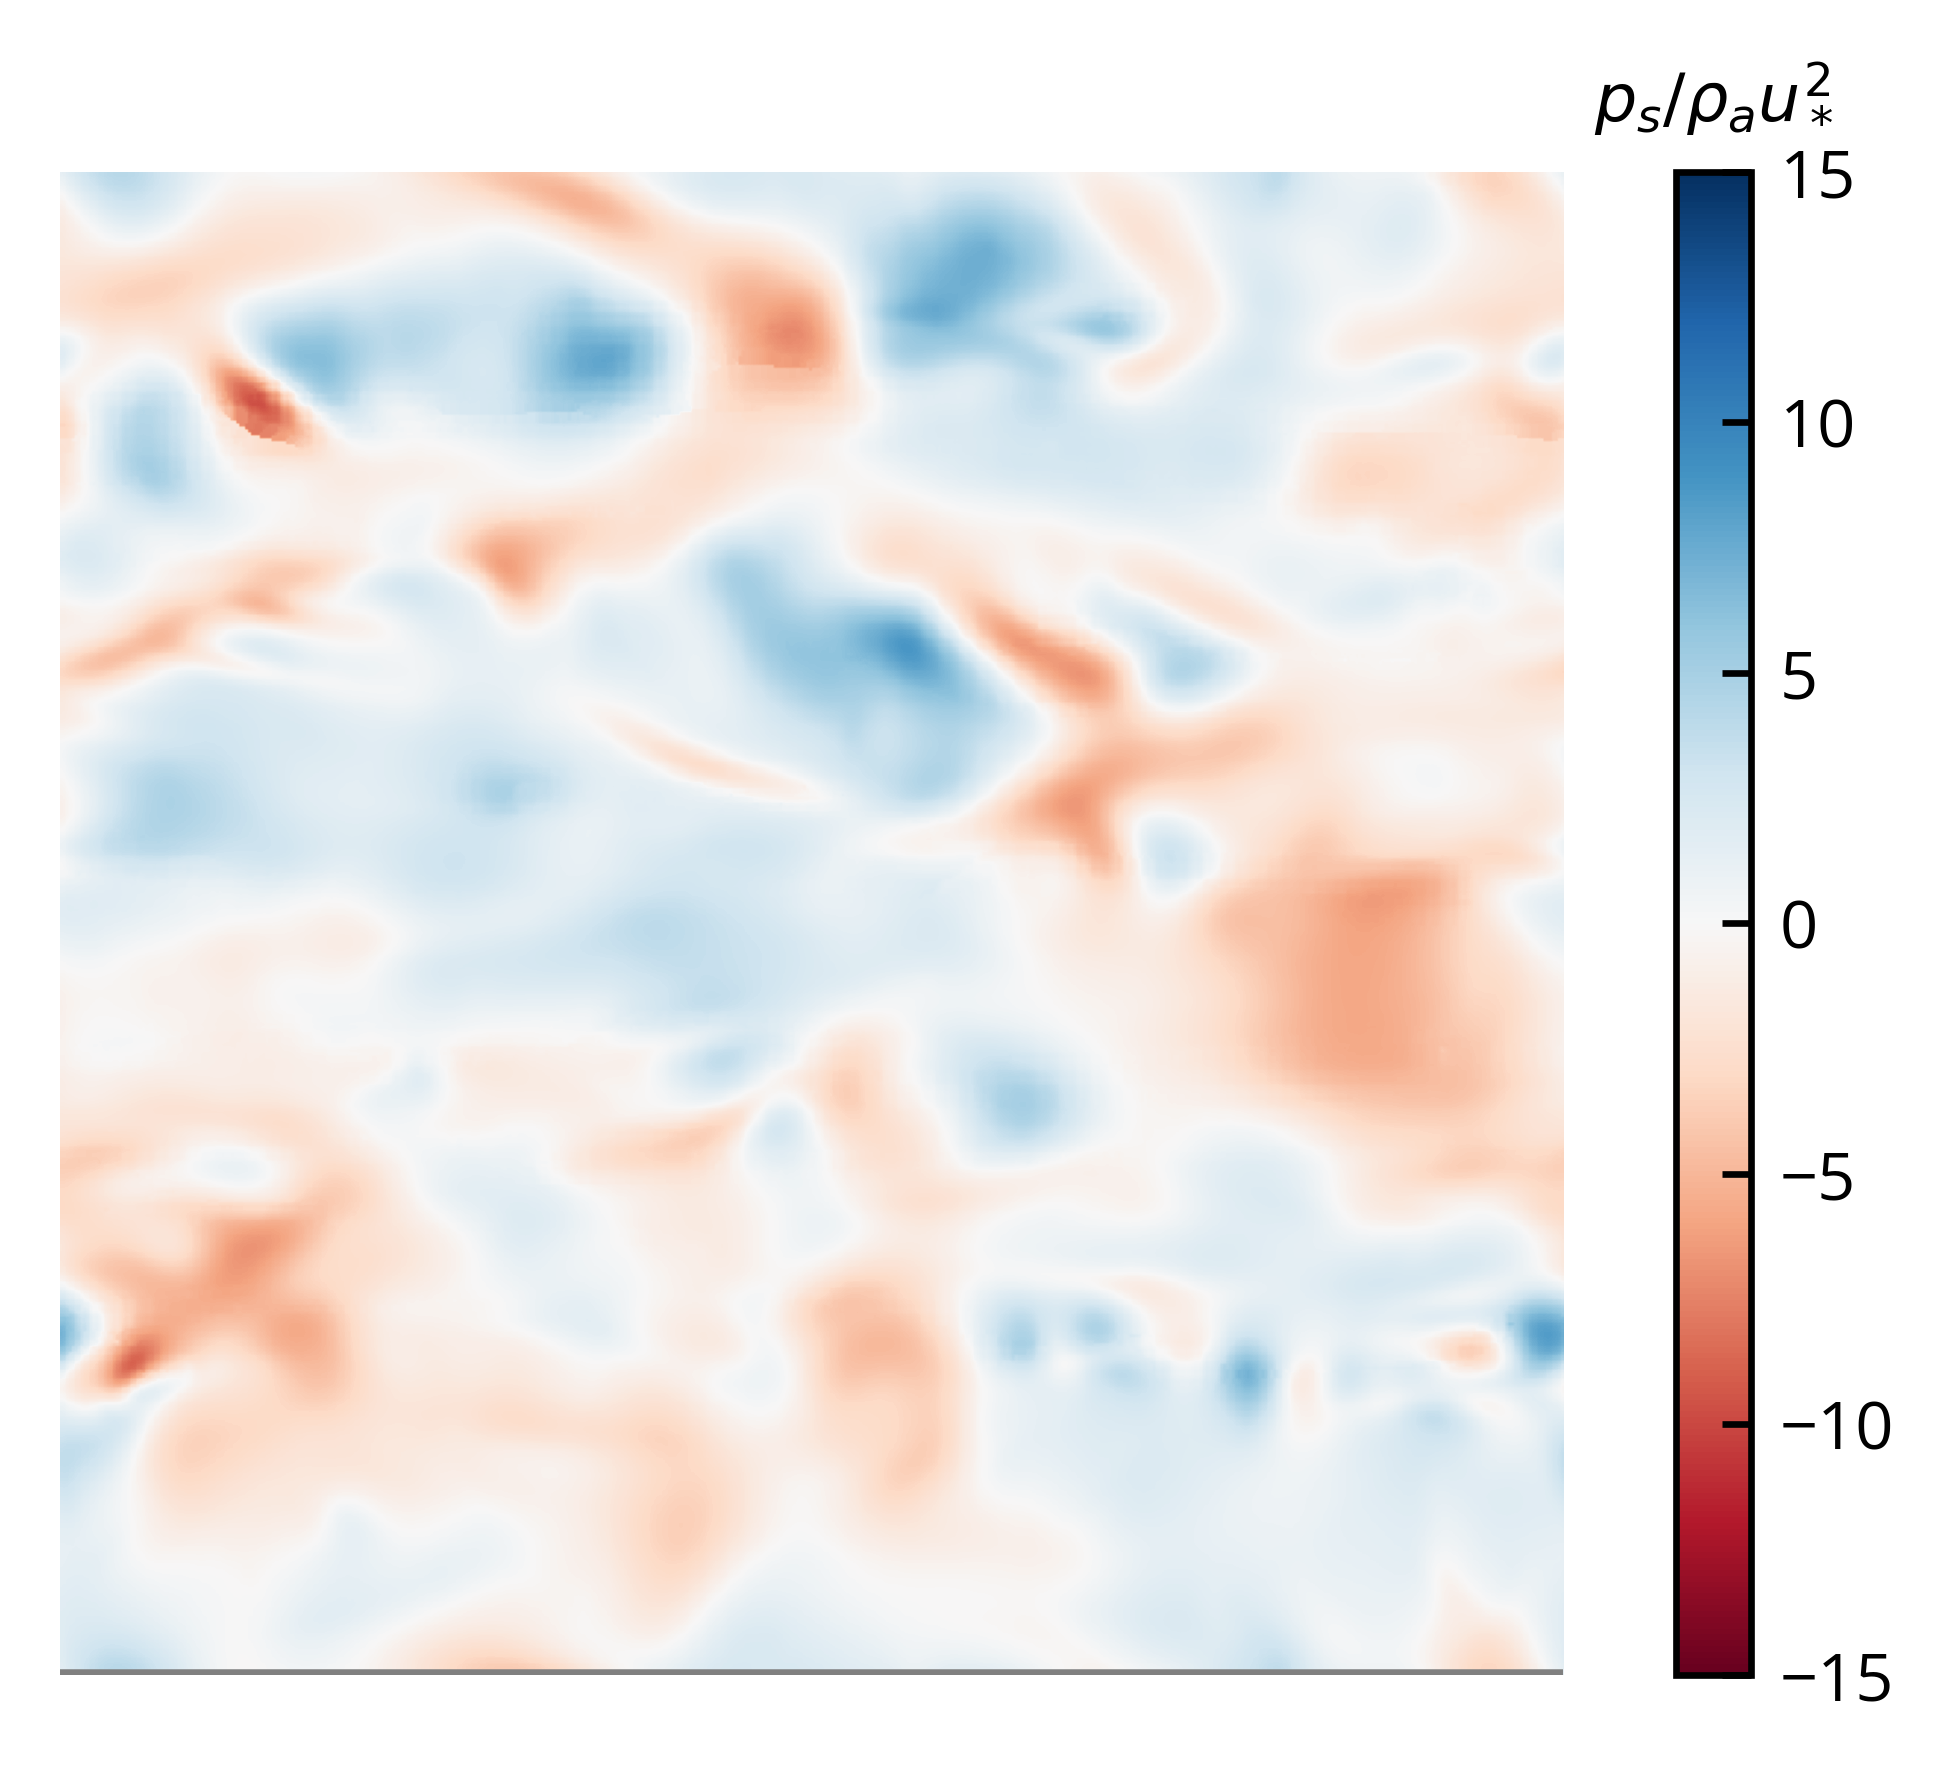

In [86]:
"""Visualization of pressure"""
fig = plt.figure(figsize=[4,3])
plt.imshow((interface.p)/tau0, cmap='RdBu', vmax = 15, vmin = -15, extent = [-L0/2,L0/2,-L0/2,L0/2])
plt.plot(interface.xarray, np.average(interface.eta,axis=0)-np.pi-1, c='gray')
ax = plt.gca()
ax.text(1.1,1.05, r'$p_s/\rho_{a}u_*^2$', ha='center', va='center', transform=ax.transAxes)
cbar = plt.colorbar(); plt.axis('off')
fig.savefig('/home/jiarong/Downloads/ICTAM/p2D_flat.pdf')

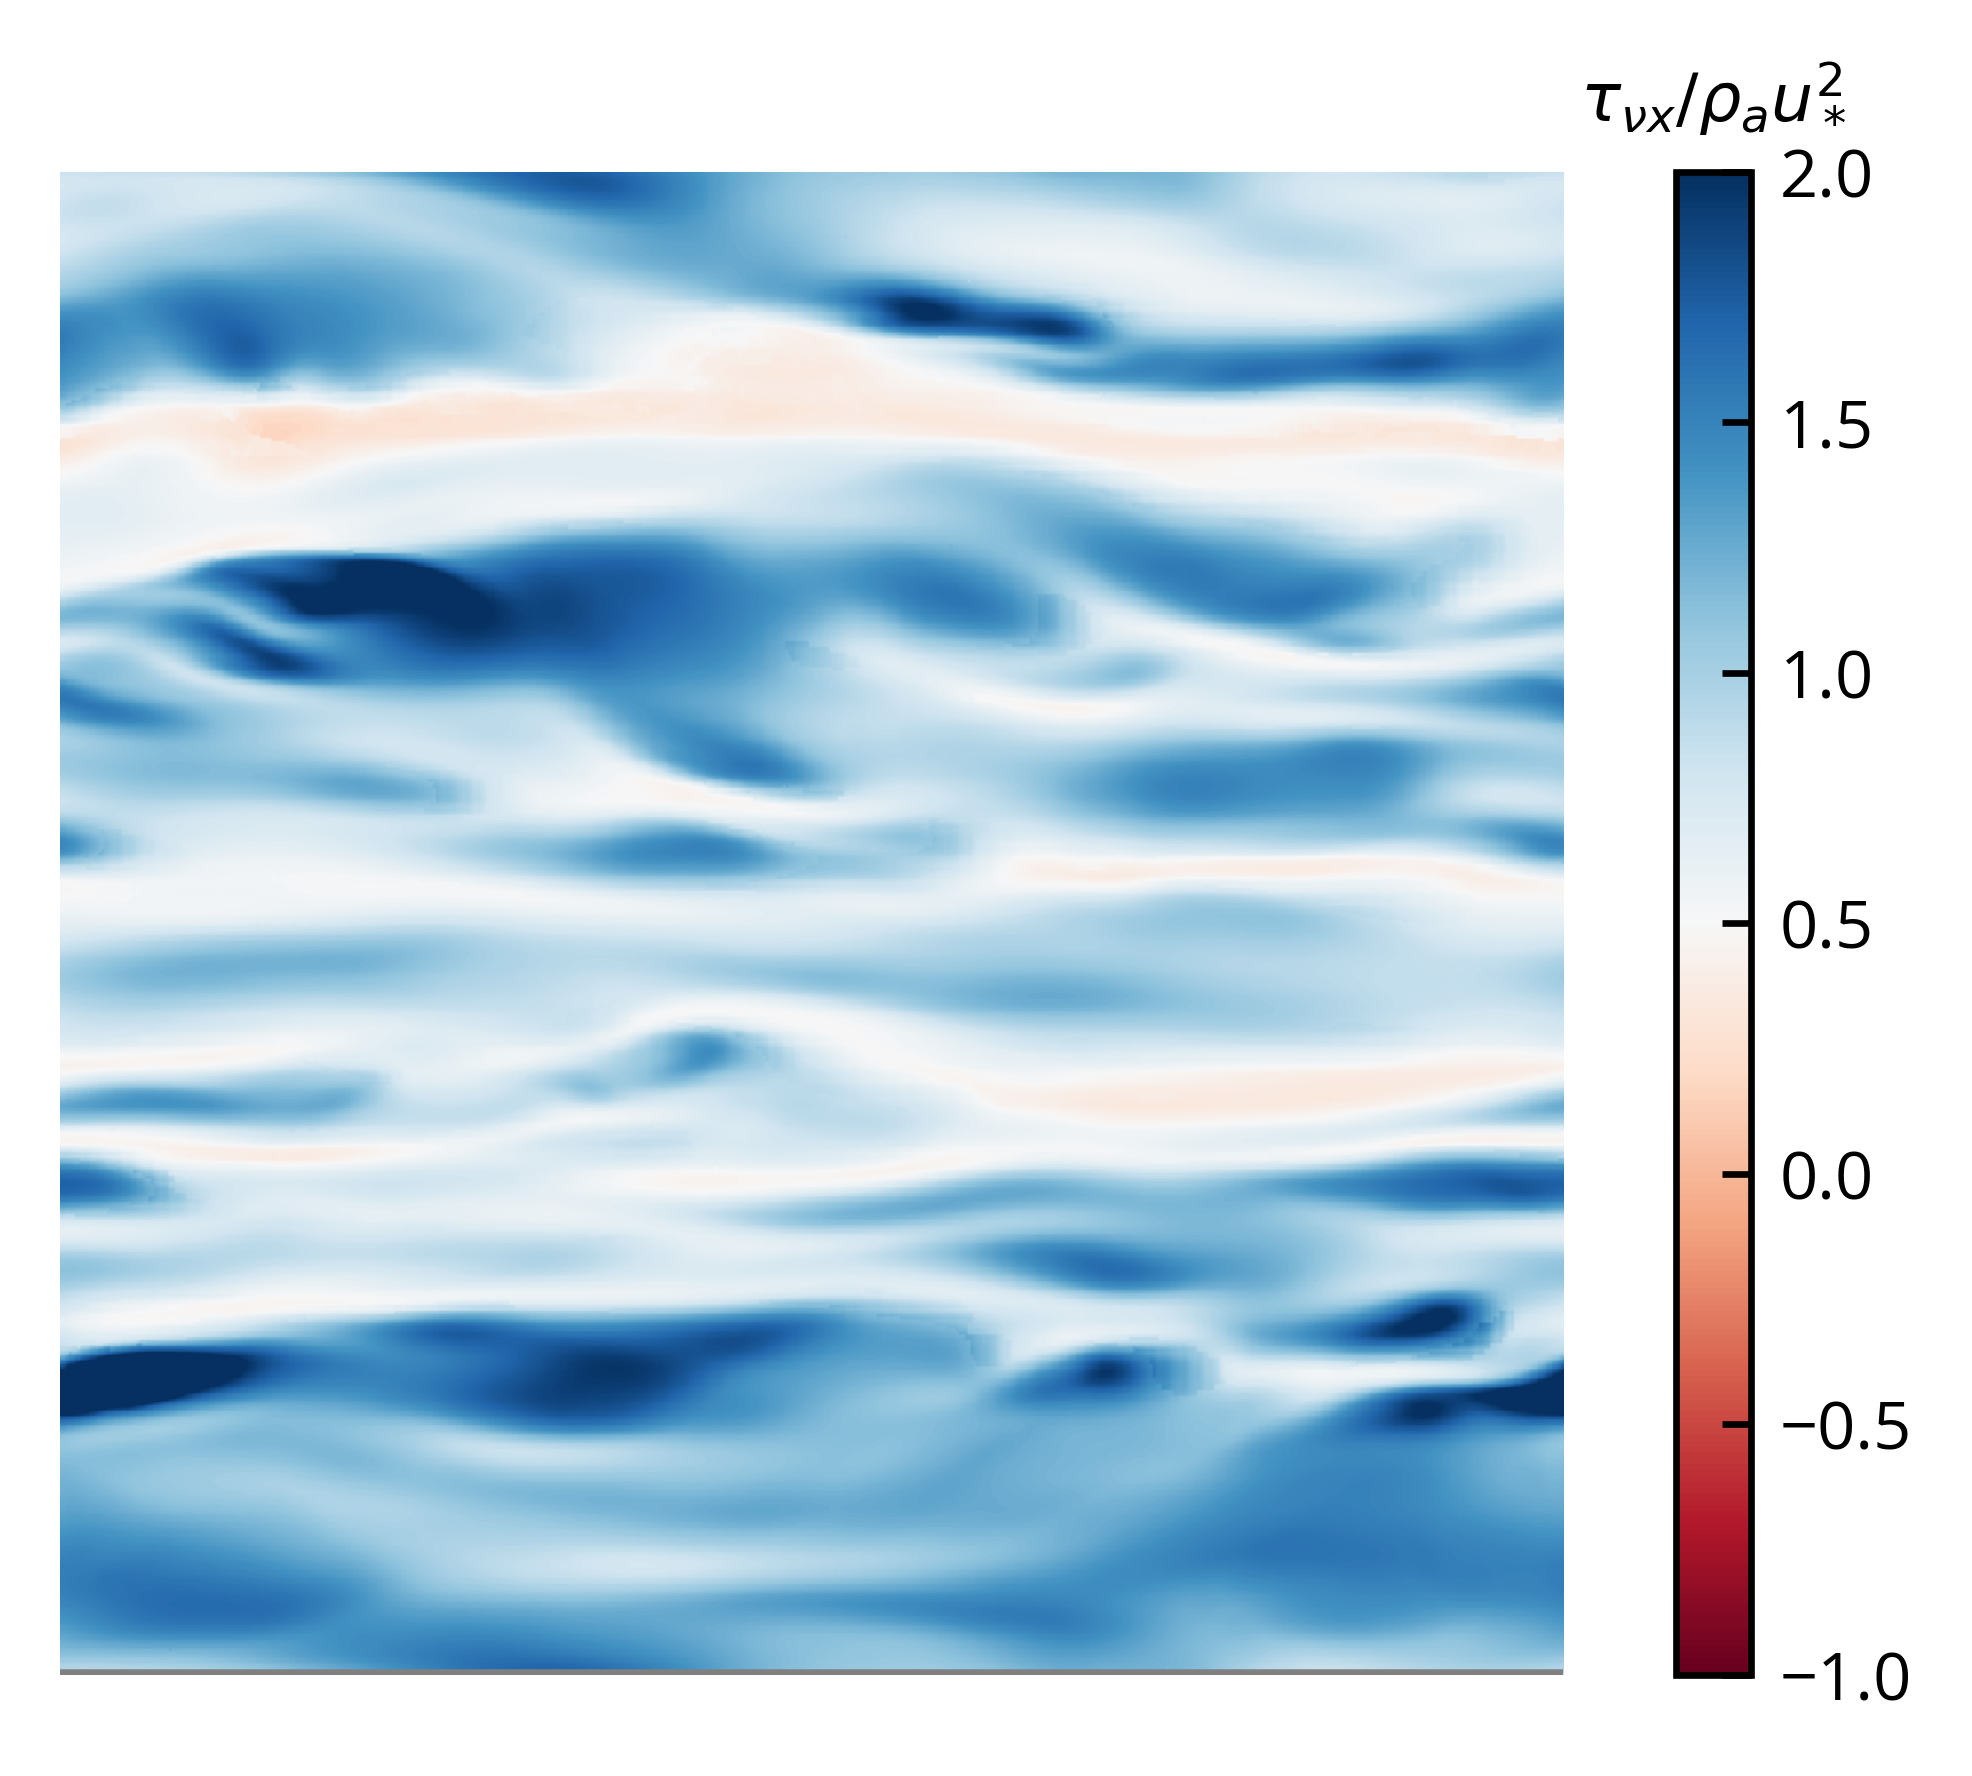

In [87]:
"""Visualization of shear stress"""
fig = plt.figure(figsize=[4,3])
plt.imshow(interface.tau_nux/tau0, cmap='RdBu', vmax = 2, vmin = -1, extent = [-L0/2,L0/2,-L0/2,L0/2])
plt.plot(interface.xarray, np.average(interface.eta,axis=0)-np.pi-1, c='gray')
ax = plt.gca()
ax.text(1.1,1.05, r'$\tau_{\nu x}/\rho_{a}u_*^2$', ha='center', va='center', transform=ax.transAxes)
cbar = plt.colorbar(); plt.axis('off')
fig.savefig('/home/jiarong/Downloads/ICTAM/shear2D_flat.pdf')

In [ ]:
plt.figure(figsize=[4,3])
plt.imshow((interface.eta_tile-np.average(interface.eta_tile))*4, cmap='RdBu', vmax = 0.3, vmin = -0.3, extent = [-L0/2,L0/2,-L0/2,L0/2])
cbar = plt.colorbar(); plt.axis('off')
ax = plt.gca()
ax.text(1.1,1.05, r'$\eta k$', ha='center', va='center', transform=ax.transAxes)

In [ ]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[4][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2), 
         label = r'$p/\rho_{a}u_*^2$', color = 'blue')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv[0][0:-1])*5/(rho_a*0.25**2), label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', label=r'$10d\eta/dx$ ', color = 'gray')
plt.xlabel(r'$x/\lambda$')
plt.ylim([-14,14])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

In [80]:
'''
Interpolate the surface pressure from the field output.
This is a serialized version of the function.
'''

from scipy.signal import hilbert
from scipy.signal import butter,filtfilt
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

# Filter requirements.
def butter_lowpass_filter(data, CUT=4):
    T = 4     # Sample Period
    fs = 512/T      # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.2_MU8_LEVEL10_emax0.3/'

NGRID = 512
rho_a = 0.001225
nu_a = 0.25*(2*np.pi-1)/720
NSLICE = 256

t = 84
''' 
Reading in pressure and immediately average over z (quasi 2D assumption).
Should change to fully 3D later. 
'''
pair = {'name':'pair', 'value':[]}
f = {'name':'f', 'value':[]}
field = pair # Later can add more field 
for sn in range(0,NSLICE-1):
    filename = working_dir + 'field/'+field['name']+'_run_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    field['value'].append(snapshot[:,0:NGRID].astype(np.float))
field['value'] = np.average(np.array(field['value']), axis=0)

# To-do: unify the name!
field = f
for sn in range(0,NSLICE-1):
    filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    field['value'].append(snapshot[:,0:NGRID].astype(np.float))
field['value'] = np.average(np.array(field['value']), axis=0)

''' Read in eta and immediately average over z'''
L0 = 2*np.pi
PRUNING = True
filename = working_dir + 'eta/eta_t%g' % t
snapshot = pd.read_table(filename, delimiter = ',')
if PRUNING:
    snapshot = snapshot[snapshot.x != 'x']
    snapshot = snapshot.astype('float')
    snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos)}
# Interpolate over x-z plane with the same resolutions
# xarray = np.linspace(-L0/2.,L0/2,NGRID)
# zarray = np.linspace(-L0/2.,L0/2,NGRID)
'''
TODO: Figure out why these two are so different!
'''
xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
x_tile, z_tile = np.meshgrid(xarray,zarray)
eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                         (x_tile, z_tile), method='nearest')
eta_1D = np.average(eta_tile, axis=0)

''' Compute 1D eta gradient '''
eta_1D_filtered = butter_lowpass_filter(eta_1D)
eta_1D_grad = np.gradient(eta_1D)/(L0/NGRID)
# eta_1D_grad[0] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
# eta_1D_grad[-1] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
eta_1D_grad_filtered = butter_lowpass_filter(eta_1D_grad)

''' Remove the constant and interpolate p '''
parray = pair['value']
farray = f['value']
pbase = np.average(parray[parray!=0])
print(pbase)
pshift = (parray-pbase)*(1-farray)
ygrid = np.linspace(0.,L0,NGRID,endpoint=False)+L0/NGRID/2
# Removing the too high point 
# that are very close to eta and might mess with the interp
pshift[pshift/0.25**2 > 0.5] = 0
# Add some distance
# Test 6 different vertical padded values
pinterp = np.zeros([6, eta_1D_grad.shape[0]])
for ix in range(0, NGRID-1):
    pgrid = interp1d(ygrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
    for NADD in range(1,7):
        pinterp[NADD-1,ix] = pgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)

''' Compute interpolated shear stress '''    
ux = {'name':'ux', 'value':[]}
uy = {'name':'uy', 'value':[]}
# TODO uy gradient
for field in (ux, uy): # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)
tauv_dudy = np.zeros([6, eta_1D_grad.shape[0]])
tauv_dvdy = np.zeros([6, eta_1D_grad.shape[0]])
tauv_dudx = np.zeros([6, eta_1D_grad.shape[0]])
tauv_dvdx = np.zeros([6, eta_1D_grad.shape[0]])
# Interpolate and then compute the gradient in y 
for ix in range(0, NGRID-1):
    uxgrid = interp1d(ygrid, ux['value'][ix,:], fill_value='extrapolate', kind='quadratic')
    uygrid = interp1d(ygrid, uy['value'][ix,:], fill_value='extrapolate', kind='quadratic')
    for NADD in range(1,7):
        ux_interp1 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
        ux_interp2 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*(NADD+1))
        tauv_dudy[NADD-1,ix] = (ux_interp2-ux_interp1)/(L0/NGRID)
        uy_interp1 = uygrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
        uy_interp2 = uygrid(eta_1D_filtered[ix] + L0/NGRID*(NADD+1))
        tauv_dvdy[NADD-1,ix] = (uy_interp2-uy_interp1)/(L0/NGRID)
# Compute the gradient in x first then interpolater
uxgrad = np.gradient(ux['value'], edge_order = 2, axis = 0)/(L0/NGRID)
uygrad = np.gradient(uy['value'], edge_order = 2, axis = 0)/(L0/NGRID)
for ix in range(0, NGRID-1):
    uxgrad_grid = interp1d(ygrid, uxgrad[ix,:], fill_value='extrapolate', kind='quadratic')
    uygrad_grid = interp1d(ygrid, uygrad[ix,:], fill_value='extrapolate', kind='quadratic')
    for NADD in range(1,7):
        tauv_dudx[NADD-1,ix] = uxgrad_grid(eta_1D_filtered[ix] + L0/NGRID*NADD)
        tauv_dvdx[NADD-1,ix] = uygrad_grid(eta_1D_filtered[ix] + L0/NGRID*NADD)

''' Compute the integrated force '''
# p force 6 values to deal with uncertainty
pforce = np.zeros(6)
for NADD in range(1,7):
    ''' TODO: determine is from 1 to -2 is the way to go '''
    pforce[NADD-1] = np.sum(pinterp[NADD-1,:]*eta_1D_grad_filtered[:])/NGRID
print (pforce/(rho_a*0.25**2))

# Compute tangential stress
# tang = np.sum(tauv[1,:]*1/(1+eta_1D_grad_filtered[:]**2)**0.5)/NGRID
# print(tang/(rho_a*0.25**2))
# pforce = np.sum(pinterp[3,:]*1/(1+(1/eta_1D_grad_filtered[:])**2)**0.5)/NGRID
# pforce = np.sum(pinterp[4,:]*eta_1D_grad_filtered[:])/NGRID
# print(pforce/(rho_a*0.25**2))

0.04738301571065997
[0.49984773 0.44717    0.4436001  0.42717181 0.41542405 0.40219744]


In [81]:
tang = np.sum(tauv_dudy[0,:])/NGRID*nu_a
print(tang/(0.25**2))

0.5612908908237532


In [ ]:
''' Additional visualization '''
ETA = False
P2D = False
P1D = True

# For 1D eta
if ETA == True:
    plt.figure(figsize=[4,1.5])
    plt.plot(xarray, eta_1D-1, label=r'$\eta(x)$')
    plt.plot(xarray, eta_1D_filtered-1, label=r'$\eta(x)$ smoothed')
    plt.plot(xarray, eta_1D_grad, label=r'$d\eta/dx$')
    plt.plot(xarray, eta_1D_grad_filtered, label=r'$d\eta/dx$ smoothed')
    plt.ylabel(r'$\eta$')
    plt.legend()

# For 2D p after adjusting constant
if P2D == True:
    fig = plt.figure(figsize=[3,4])
    img = plt.imshow((np.rot90((pshift)*(1-farray))/(rho_a*0.25**2)), cmap='RdBu', vmax = 10, vmin = -10, extent = [-L0/2,L0/2,0,L0])
    plt.axis('off')
    cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
#     cbar.ax.text(0, 30, r'$p/\rho_{a}u_*^2$', ha='center', va='center')
    # Demo the eta choice
    plt.plot(xarray, eta_1D_filtered, lw=0.5, c='k')
    NADD = 2
    plt.plot(xarray, eta_1D_filtered+L0/NGRID*NADD, '--', lw=0.5, c='k')

# For 1D interpolated p
if P1D == True:
    plt.figure(figsize=[4,2])
    for (i,p) in enumerate(pinterp):
        plt.plot(xarray, p/(rho_a*0.25**2), label='%g grid pts above' %(i+1))
    # plt.plot(xgrid, pinterp2/0.25**2, label='%g grid pts above' %NADD2)
    plt.ylim([-40,40])
    plt.xlabel('x'); plt.ylabel(r'$p/\rho_{a}u_*^2$')
    plt.legend()

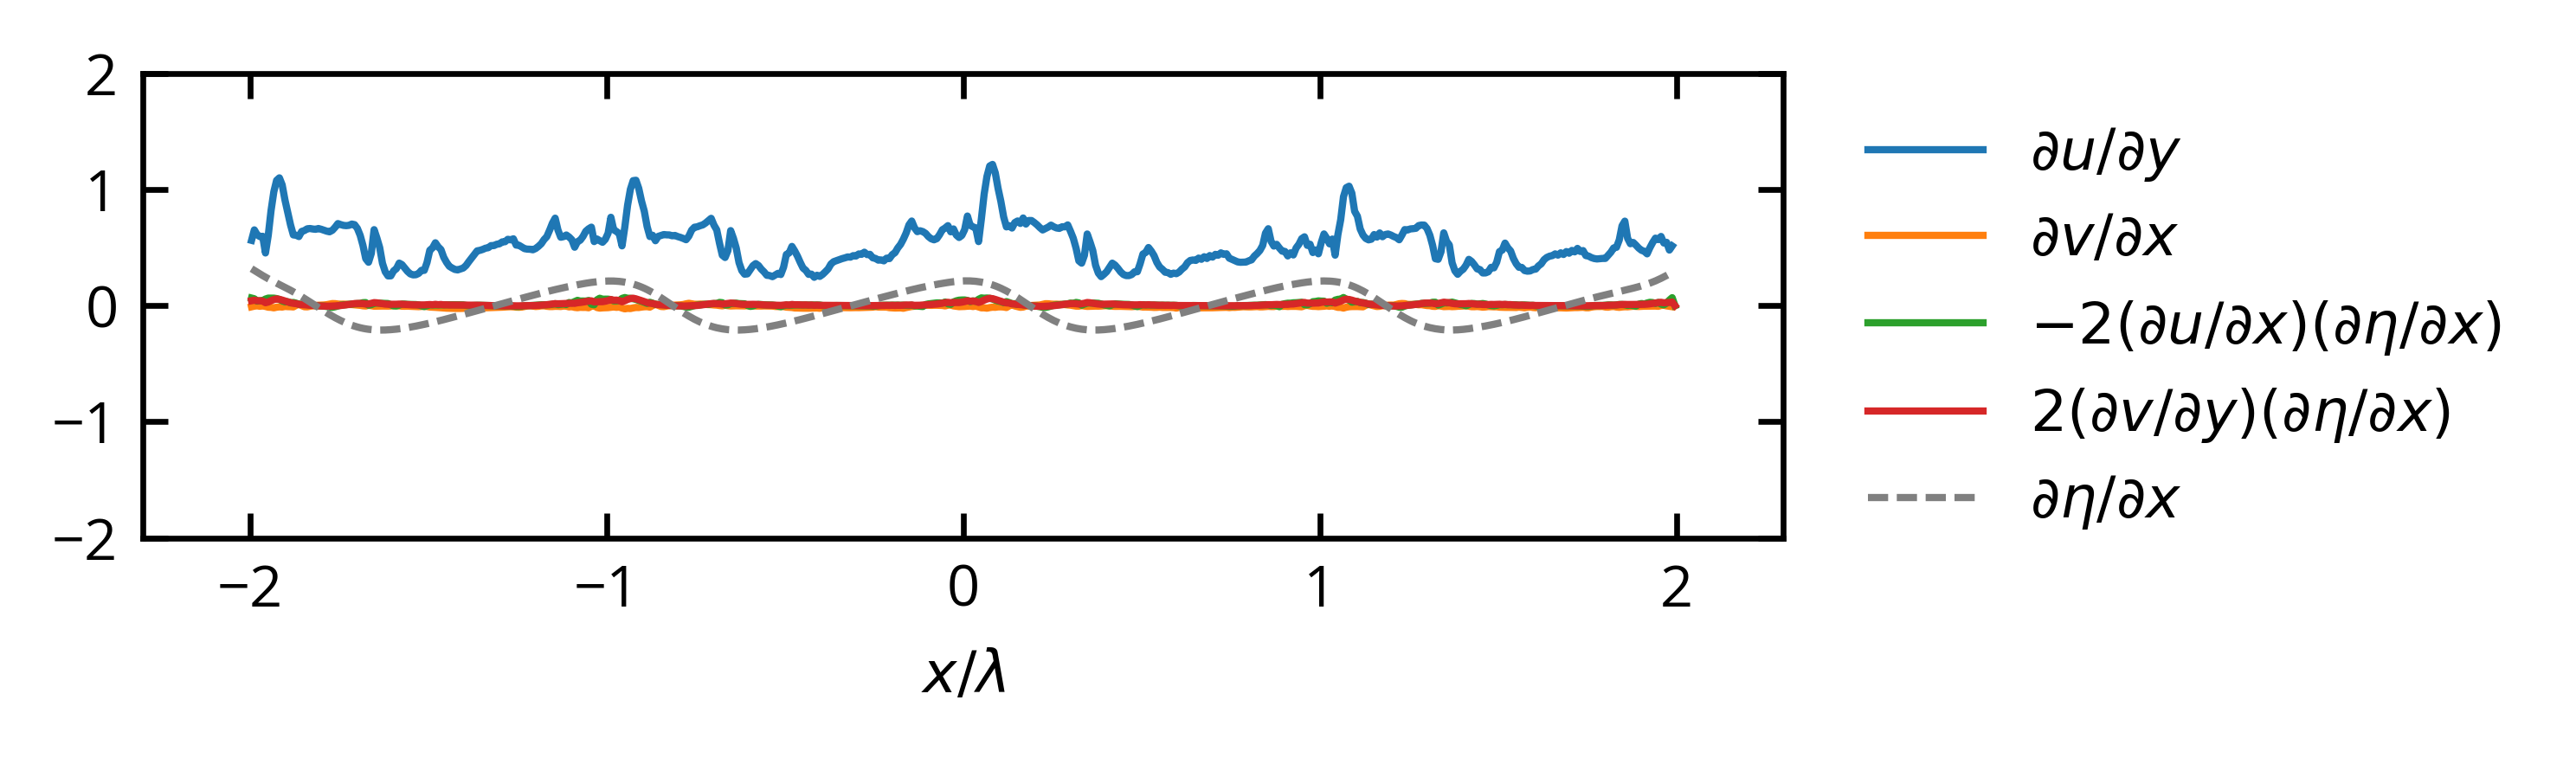

In [46]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dudy[1][0:-1])*nu_a/(0.25**2), 
         label = r'$ \partial u / \partial y $', lw = 1)
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dvdx[1][0:-1])*nu_a/(0.25**2), 
         label = r'$ \partial v / \partial x $', lw = 1)
plt.plot(xarray/(2*np.pi/4), (-2*tauv_dudx[1])*nu_a/(0.25**2)*eta_1D_grad_filtered, 
         label = r'$ -2 (\partial u / \partial x) (\partial \eta/\partial x)$', lw = 1)
plt.plot(xarray/(2*np.pi/4), (2*tauv_dvdy[1])*nu_a/(0.25**2)*eta_1D_grad_filtered, 
         label = r'$ 2 (\partial v / \partial y) (\partial \eta/\partial x)$', lw = 1)
# plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4, label=r'$\eta(x)k $', color = 'gray', lw = 1)
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered, '--', label=r'$\partial \eta/\partial x$ ', color = 'gray', lw = 1)
plt.xlabel(r'$x/\lambda$')
plt.ylim([-2,2])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

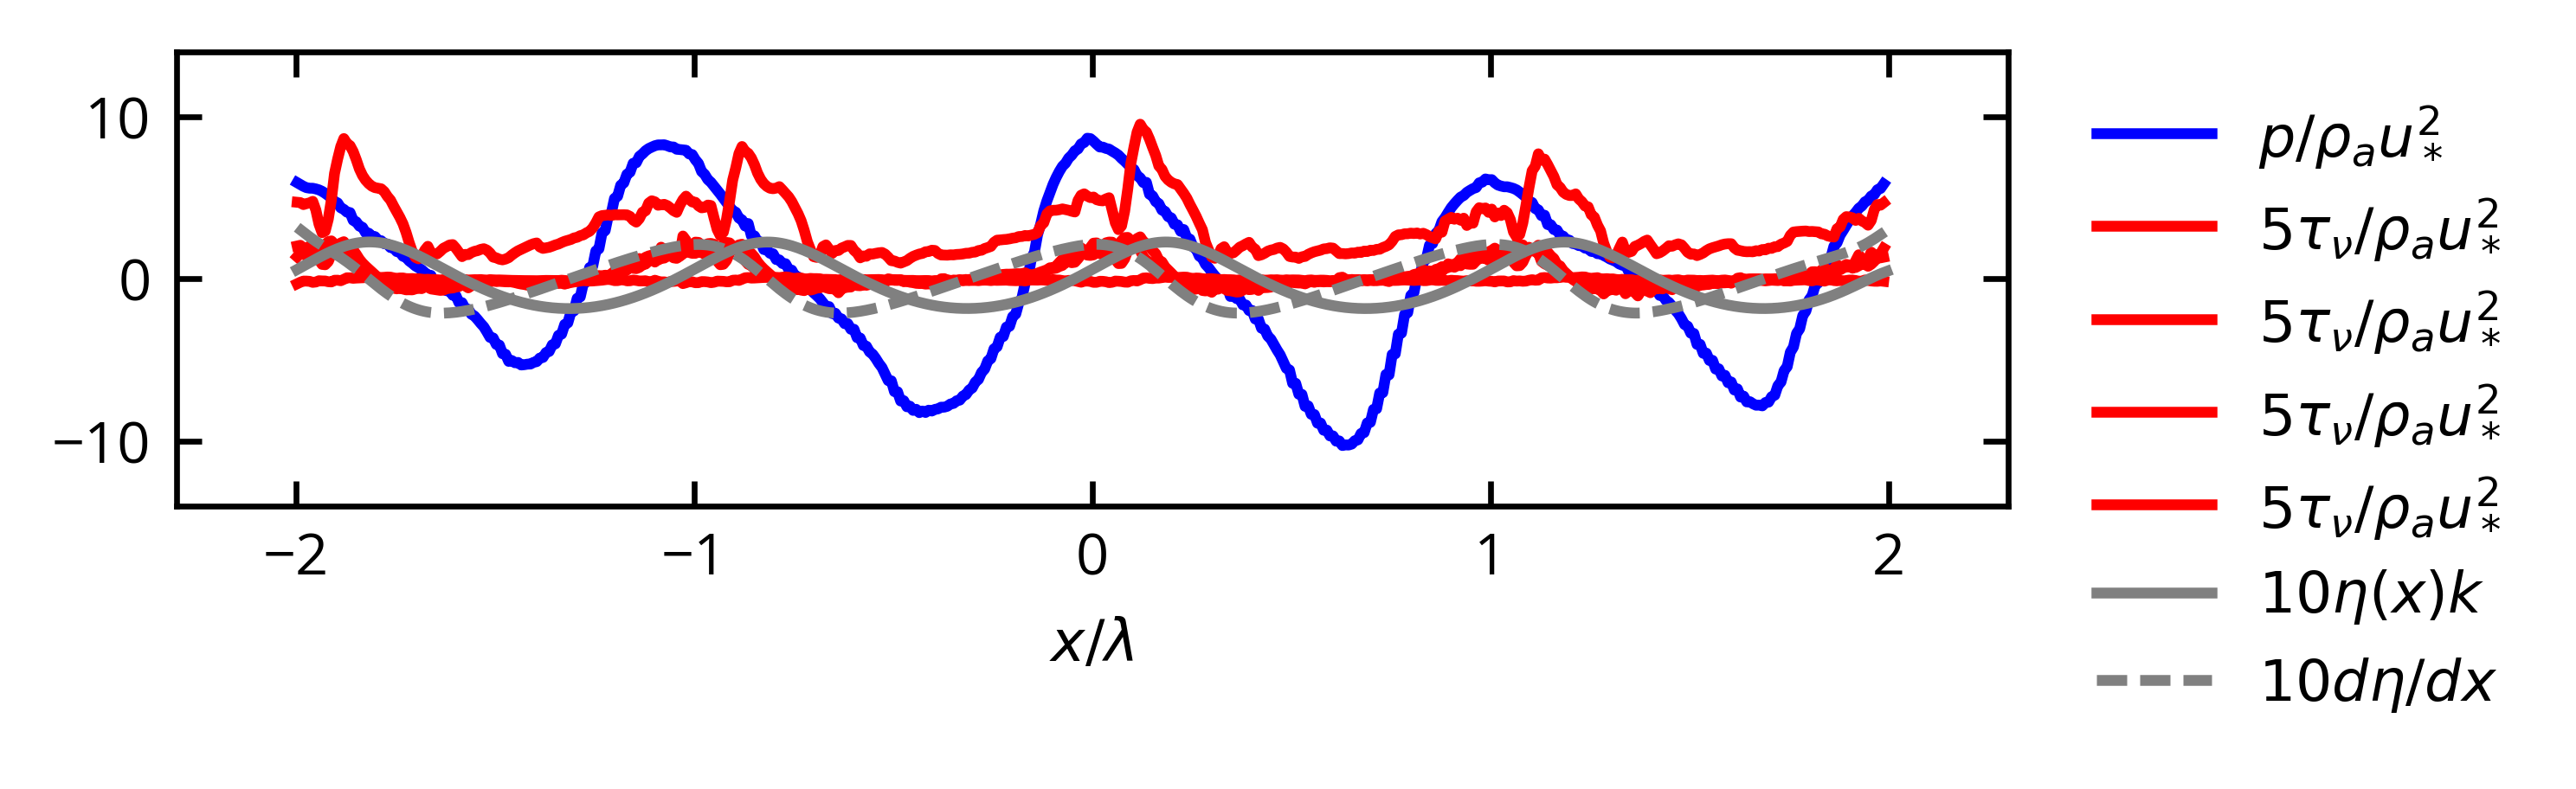

In [29]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[4][0:-1]-np.average(pinterp[4][0:-1]))/(rho_a*0.25**2), 
         label = r'$p/\rho_{a}u_*^2$', color = 'blue')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dudy[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv_dvdx[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray[0:-1]/(2*np.pi/4), (-2*tauv_dudx[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray[0:-1]/(2*np.pi/4), (2*tauv_dvdy[0][0:-1])*5*nu_a/(0.25**2), 
         label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', label=r'$10d\eta/dx$ ', color = 'gray')
plt.xlabel(r'$x/\lambda$')
plt.ylim([-14,14])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

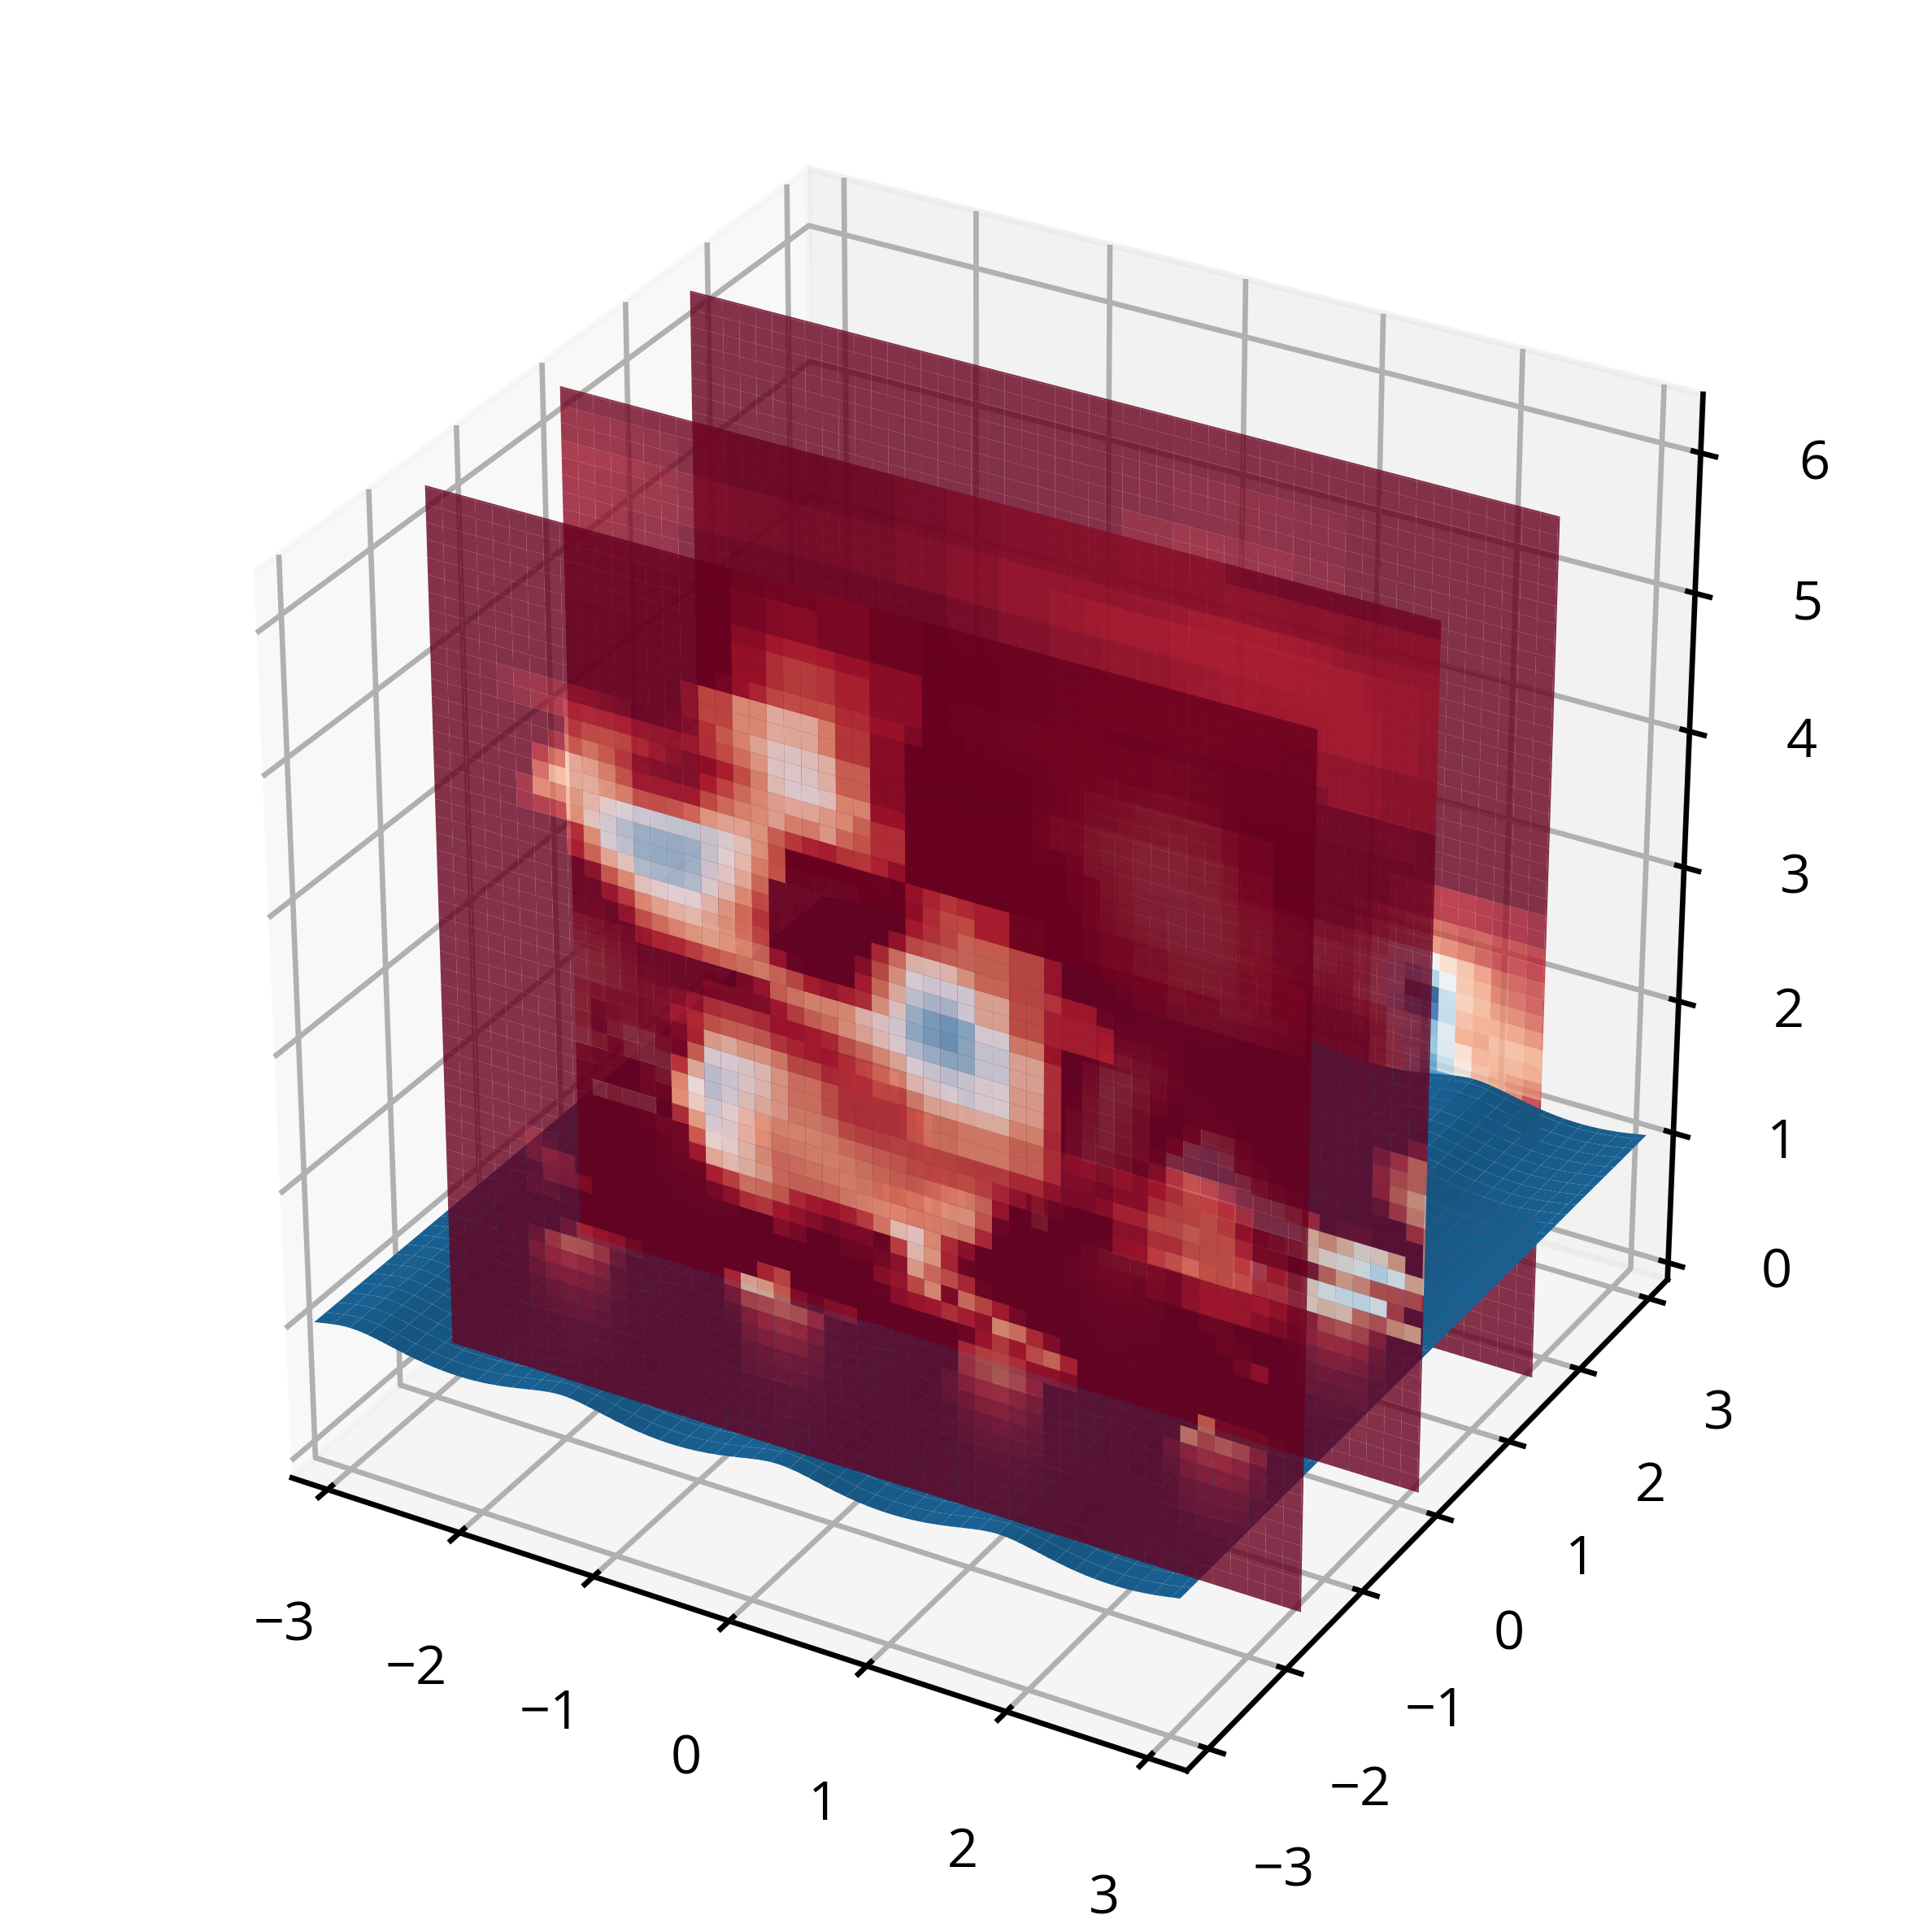

In [48]:
'''
Demonstrating the data processing process. Reference: 
https://stackoverflow.com/questions/25287861/creating-intersecting-images-in-matplotlib-with-imshow-or-other-function/25295272#25295272
https://stackoverflow.com/questions/30464117/plotting-a-imshow-image-in-3d-in-matplotlib
https://matplotlib.org/2.2.2/mpl_toolkits/mplot3d/faq.html
'''
from mpl_toolkits.mplot3d import Axes3D

# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')

# create a 512*512 vertex mesh
xx, zz = np.meshgrid(np.linspace(-np.pi,np.pi,512), np.linspace(0.,2*np.pi,512))
# create vertices for a rotated mesh (3D rotation matrix)
X = xx 
Z = zz
# Take a few slices
t = 68
for sn in range(64,256,64):
    Y = (-np.pi + 2.*np.pi/256*sn)*np.ones([512,512])
    filename = working_dir + 'field/'+'uy'+'_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    data = snapshot.reshape([NGRID,NGRID+1])
    data = np.rot90(data[:,0:-1].astype(np.float), 3)
    # show the 3D rotated projection
    ax.plot_surface(X, Y, Z, rstride=10, cstride=10, facecolors=plt.cm.RdBu(data), 
                    alpha = 0.8, linewidth=0, shade=False)

xx, yy = np.meshgrid(np.linspace(-np.pi,np.pi,512), np.linspace(-np.pi,np.pi,512))
ax.plot_surface(xx, yy, interface.eta_tile)
ax.set_xlim([-np.pi, np.pi]); ax.set_ylim([-np.pi, np.pi]); ax.set_zlim([0., 2.*np.pi])
plt.show()

In [ ]:
from scipy.signal import hilbert

from scipy.signal import butter,filtfilt
# Filter requirements.
def butter_lowpass_filter(data, CUT=4):
    T = 4     # Sample Period
    fs = 512/T      # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

class Snapshot:
    '''
    Class for every snapchat
    self.availt: The longest running time
    self.path: Path of the case file
    
    '''  
    def __init__(self, t, working_dir, NSLICE=256, NGRID=256, L0=np.pi*2, trans=False):
        '''
        trans: if phase shift is needed
        self.eta_raw: raw x,z,eta data
        self.eta_tile,self.x_tile,self.z_tile: interpolated eta,x,z with resolution specified by NGRID
        self.eta_1D: eta averaged over z direction
        '''
        self.t = t
        # Declare the fields (do not store as class attribution because of memory issues)
        ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
        uy_3D = {'name':'uy', 'value':[]}
        # Read in the fields
        for field in (ux_3D,uy_3D):
            for sn in range (0,NSLICE-1):
                filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (self.t,sn)
                snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                snapshot.reshape([NGRID,NGRID+1])
                field['value'].append(snapshot[:,0:NGRID].astype(np.float))
            field['value'] = np.array(field['value'])
        # Read in eta
        filename = working_dir + 'eta/eta_t%g' % self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        self.eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos),
                       'p1':np.array(snapshot.p_p1), 'p2':np.array(snapshot.p_p2)}
        # Interpolate over x-z plane with the same resolutions
        xarray = np.linspace(-L0/2,L0/2,NGRID); zarray = np.linspace(-L0/2,L0/2,NGRID)
        self.x_tile, self.z_tile = np.meshgrid(xarray,zarray)
        self.eta_tile = griddata((self.eta_raw['x'].ravel(), self.eta_raw['z'].ravel()), self.eta_raw['eta'].ravel(), 
                                 (self.x_tile, self.z_tile), method='nearest')
        # !To-dos: test for non quasi 1D cases
        self.eta_1D = np.average(self.eta_tile, axis=0)
        # Compute the Reynolds stress
#         self.ux_1D = np.average(ux_3D['value'], axis=(0,1))
#         self.uy_1D = np.average(uy_3D['value'], axis=(0,1))
#         ux_1D_broadcast = np.tile(self.ux_1D, (NSLICE-1, NGRID, 1))
#         uy_1D_broadcast = np.tile(self.uy_1D, (NSLICE-1, NGRID, 1))
#         re_stress_3D = (ux_3D['value']-ux_1D_broadcast)*(uy_3D['value']-uy_1D_broadcast)
#         # Include only z direction averaged 2D profile
#         self.ux_2D = np.average(ux_3D['value'], axis=0)
#         self.uy_2D = np.average(uy_3D['value'], axis=0)
#         self.re_stress_2D = np.average(re_stress_3D,axis=0)             
        # Hilbert transform, performed along x        
        # Filter the data (subtract the mean)
        if trans == True:
            self.eta_1D_filtered = butter_lowpass_filter(self.eta_1D-np.average(self.eta_1D))
            analytic_signal = hilbert(self.eta_1D_filtered)
            self.phase = np.angle(analytic_signal)
            # Shift the velocity field along x axis so that phase starts at 0
            self.idx = (np.abs(self.phase - 0)).argmin()
            self.eta_1D_shift = np.roll(self.eta_1D, -self.idx)
#             self.ux_3D_shift = {'name':'ux_shift', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
#             self.uy_3D_shift = {'name':'uy_shift', 'value':[]}
#             for (field,field_shift) in zip((self.ux_3D,self.uy_3D),(self.ux_3D_shift,self.uy_3D_shift)):
#                 field_shift['value'] = np.roll(field['value'], -self.idx, axis=1)

In [ ]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
# snapshot_ensemble_360_moving_MU32 = []
for i in tqdm(range(0,1)):
    t = 76 + i
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)

In [ ]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
# snapshot_ensemble_360_moving_MU32 = []
for i in tqdm(range(0,1)):
    t = 57 + i
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)

In [ ]:
from scipy.interpolate import interp1d
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
# working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_precursor_REtau720_ak0.2_LEVEL10_emax0.3/'
# t = 59

def pressure(t, PRUNING = True):
    '''
    This is a function that compute the integrated form drag at time t
    '''
    
    NGRID = 512
    rho_a = 0.001225
    nu_a = 0.25*(2*np.pi-1)/720
    ''' 
    Reading in pressure and immediately average over z (quasi 2D assumption).
    Should change to fully 3D later. 
    '''
    pair = {'name':'pair', 'value':[]}
    f = {'name':'f', 'value':[]}
    field = pair # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_run_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)
    # To-do: unify the name!
    field = f
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)

    ''' Read in eta and immediately average over z'''
    L0 = 2*np.pi
    filename = working_dir + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    if PRUNING:
        snapshot = snapshot[snapshot.x != 'x']
        snapshot = snapshot.astype('float')
        snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
    eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos), 'p1':np.array(snapshot.p_p1), 'p2':np.array(snapshot.p_p2)}
    # Interpolate over x-z plane with the same resolutions
#     xarray = np.linspace(-L0/2.,L0/2,NGRID)
#     zarray = np.linspace(-L0/2.,L0/2,NGRID)
    '''
    TODO: Figure out why these two are so different!
    '''
    xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                             (x_tile, z_tile), method='nearest')
    eta_1D = np.average(eta_tile, axis=0)

    ''' Comupte 1D eta gradient '''
    eta_1D_filtered = butter_lowpass_filter(eta_1D)
    eta_1D_grad = np.gradient(eta_1D)/(L0/NGRID)
    # eta_1D_grad[0] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    # eta_1D_grad[-1] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    eta_1D_grad_filtered = butter_lowpass_filter(eta_1D_grad)

    ''' Remove the constant and interpolate p '''
    parray = pair['value']
    farray = f['value']
    pbase = np.average(parray[parray!=0])
    pshift = (parray-pbase)*(1-farray)
    ygrid = np.linspace(0.,L0,NGRID,endpoint=False)+L0/NGRID/2
    # Removing the too high point 
    # that are very close to eta and might mess with the interp
    pshift[pshift/0.25**2 > 0.01] = 0
    # Add some distance
    NADD1 = 1
    pinterp1 = np.zeros(eta_1D_grad.shape[0])
    for ix in range(0, NGRID-1):
        pgrid = interp1d(ygrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
        pinterp1[ix] = pgrid(eta_1D_filtered[ix] + L0/NGRID*NADD1)
    # NADD2 = 2
    # pinterp2 = np.zeros(eta_1D_grad.shape[0])
    # for ix in range(0, NGRID-1):
    #     pgrid = interp1d(zgrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
    #     pinterp2[ix] = pgrid(eta_1D_filtered[ix]+L0/NGRID*NADD2)

    ''' Compute the integrated force '''
    pforce1 = np.sum(pinterp1*eta_1D_grad_filtered)/NGRID
#     print ('t = %g, pforce = %g' %(t, pforce1/(rho_a*0.25**2)))
    return pforce1

print(pressure(60)/(rho_a*0.25**2))

In [ ]:
t_ensemble = [60,63,66,69]
pforce = np.zeros(4)
for i in tqdm(range(0,4)):
    pforce[i] = pressure(t_ensemble[i])
    print(pforce[i]/(rho_a*0.25**2))

In [ ]:
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_precursor_REtau720_ak0.2_LEVEL10_emax0.3/'
print(pressure(59, PRUNING=False)/(rho_a*0.25**2))

In [ ]:
0.25*(2*np.pi-1)/720*0.001225

In [ ]:
'''
This is a serialized version of the function
'''
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
working_dir = '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'

NGRID = 512
rho_a = 0.001225
nu_a = 0.25*(2*np.pi-1)/720
pforce_ensem = []

for t in tqdm(range(78,79,3)):
    ''' 
    Reading in pressure and immediately average over z (quasi 2D assumption).
    Should change to fully 3D later. 
    '''
    pair = {'name':'pair', 'value':[]}
    f = {'name':'f', 'value':[]}
    field = pair # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_run_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)

    # To-do: unify the name!
    field = f
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)

    ''' Read in eta and immediately average over z'''
    L0 = 2*np.pi
    PRUNING = True
    filename = working_dir + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    if PRUNING:
        snapshot = snapshot[snapshot.x != 'x']
        snapshot = snapshot.astype('float')
        snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
    eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos), 'p1':np.array(snapshot.p_p1), 'p2':np.array(snapshot.p_p2)}
    # Interpolate over x-z plane with the same resolutions
    # xarray = np.linspace(-L0/2.,L0/2,NGRID)
    # zarray = np.linspace(-L0/2.,L0/2,NGRID)
    '''
    TODO: Figure out why these two are so different!
    '''
    xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                             (x_tile, z_tile), method='nearest')
    eta_1D = np.average(eta_tile, axis=0)

    ''' Comupte 1D eta gradient '''
    eta_1D_filtered = butter_lowpass_filter(eta_1D)
    eta_1D_grad = np.gradient(eta_1D)/(L0/NGRID)
    # eta_1D_grad[0] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    # eta_1D_grad[-1] = (eta_1D_filtered[1]-eta_1D_filtered[-1])/2./(L0/NGRID)
    eta_1D_grad_filtered = butter_lowpass_filter(eta_1D_grad)

    ''' Remove the constant and interpolate p '''
    parray = pair['value']
    farray = f['value']
    pbase = np.average(parray[parray!=0])
    print(pbase)
    pshift = (parray-pbase)*(1-farray)
    ygrid = np.linspace(0.,L0,NGRID,endpoint=False)+L0/NGRID/2
    # Removing the too high point 
    # that are very close to eta and might mess with the interp
    pshift[pshift/0.25**2 > 0.5] = 0
    # Add some distance
    # Test 6 different vertical padded values
    pinterp = np.zeros([6, eta_1D_grad.shape[0]])
    for ix in range(0, NGRID-1):
        pgrid = interp1d(ygrid, pshift[ix,:], fill_value='extrapolate', kind='quadratic')
        for NADD in range(1,7):
            pinterp[NADD-1,ix] = pgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
    
    ''' Compute interpolated shear stress '''    
    ux = {'name':'ux', 'value':[]}
    # TODO uy gradient
    field = ux # Later can add more field 
    for sn in range(0,NSLICE-1):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'].append(snapshot[:,0:NGRID].astype(np.float))
    field['value'] = np.average(np.array(field['value']), axis=0)
    tauv = np.zeros([6, eta_1D_grad.shape[0]])
    for ix in range(0, NGRID-1):
        uxgrid = interp1d(ygrid, ux['value'][ix,:], fill_value='extrapolate', kind='quadratic')
        for NADD in range(1,7):
            ux_interp1 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*NADD)
            ux_interp2 = uxgrid(eta_1D_filtered[ix] + L0/NGRID*(NADD+1))
            tauv[NADD-1,ix] = (ux_interp2-ux_interp1)/(L0/NGRID)*nu_a*rho_a

    ''' Compute the integrated force '''
    pforce = np.zeros(6)
    for NADD in range(1,7):
        ''' TODO: determine is from 1 to -2 is the way to go '''
        pforce[NADD-1] = np.sum(pinterp[NADD-1,:]*eta_1D_grad_filtered[:])/NGRID
    print (pforce/(rho_a*0.25**2))
    pforce_ensem.append(pforce[3])

# print (pforce_ensem/(rho_a*0.25**2))

In [ ]:
tang = np.sum(tauv[1,:]*1/(1+eta_1D_grad_filtered[:]**2)**0.5)/NGRID
print(tang/(rho_a*0.25**2))
# pforce = np.sum(pinterp[3,:]*1/(1+(1/eta_1D_grad_filtered[:])**2)**0.5)/NGRID
pforce = np.sum(pinterp[4,:]*eta_1D_grad_filtered[:])/NGRID
print(pforce/(rho_a*0.25**2))

In [ ]:
xarray = np.linspace(-L0/2.,L0/2,NGRID)
yarray = np.linspace(0,L0,NGRID)
y_tile, x_tile = np.meshgrid(yarray,xarray)

In [ ]:
''' Additional visualization '''
ETA = False
P2D = False
P1D = True

# For 1D eta
if ETA == True:
    plt.figure(figsize=[4,1.5])
    plt.plot(xarray, eta_1D-1, label=r'$\eta(x)$')
    plt.plot(xarray, eta_1D_filtered-1, label=r'$\eta(x)$ smoothed')
    plt.plot(xarray, eta_1D_grad, label=r'$d\eta/dx$')
    plt.plot(xarray, eta_1D_grad_filtered, label=r'$d\eta/dx$ smoothed')
    plt.ylabel(r'$\eta$')
    plt.legend()

# For 2D p after adjusting constant
if P2D == True:
    fig = plt.figure(figsize=[3,4])
    img = plt.imshow((np.rot90((pshift)*(1-farray))/(rho_a*0.25**2)), cmap='RdBu', vmax = 10, vmin = -10, extent = [-L0/2,L0/2,0,L0])
    plt.axis('off')
    cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
#     cbar.ax.text(0, 30, r'$p/\rho_{a}u_*^2$', ha='center', va='center')
    # Demo the eta choice
    plt.plot(xarray, eta_1D_filtered, lw=0.5, c='k')
    NADD = 2
    plt.plot(xarray, eta_1D_filtered+L0/NGRID*NADD, '--', lw=0.5, c='k')

# For 1D interpolated p
if P1D == True:
    plt.figure(figsize=[4,2])
    for (i,p) in enumerate(pinterp):
        plt.plot(xarray, p/(rho_a*0.25**2), label='%g grid pts above' %(i+1))
    # plt.plot(xgrid, pinterp2/0.25**2, label='%g grid pts above' %NADD2)
    plt.ylim([-40,40])
    plt.xlabel('x'); plt.ylabel(r'$p/\rho_{a}u_*^2$')
    plt.legend()

In [ ]:
plt.figure(figsize=[5,1.5])
plt.plot(xarray[0:-1]/(2*np.pi/4), (pinterp[4][0:-1]-np.average(pinterp[3][0:-1]))/(rho_a*0.25**2), 
         label = r'$p/\rho_{a}u_*^2$', color = 'blue')
plt.plot(xarray[0:-1]/(2*np.pi/4), (tauv[1][0:-1])*5/(rho_a*0.25**2), label = r'$5\tau_{\nu}/\rho_{a}u_*^2$', color = 'red')
plt.plot(xarray/(2*np.pi/4), (eta_1D_filtered-1)*4*10, label=r'$10\eta(x)k $', color = 'gray')
plt.plot(xarray/(2*np.pi/4), eta_1D_grad_filtered*10, '--', label=r'$10d\eta/dx$ ', color = 'gray')
plt.xlabel(r'$x/\lambda$')
plt.ylim([-14,14])
plt.xlim([-2.3,2.3])
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

In [ ]:
pforce1 = np.zeros(6); pforce2 = np.zeros(6); pforce3 = np.zeros(6)
for NADD in range(1,7):
    ''' TODO: determine is from 1 to -2 is the way to go '''
    pforce1[NADD-1] = np.sum(pinterp[NADD-1,1:-2]*eta_1D_grad_filtered[1:-2])/NGRID
    pforce2[NADD-1] = np.sum(pinterp[NADD-1,0:-1]*eta_1D_grad_filtered[0:-1])/NGRID
    pforce3[NADD-1] = np.sum((pinterp[NADD-1,:])*eta_1D_grad_filtered[:])/NGRID

In [ ]:
plt.plot(pforce1/(rho_a*0.25**2),'.')
plt.plot(pforce2/(rho_a*0.25**2),'.')
plt.plot(pforce3/(rho_a*0.25**2),'.')

In [ ]:
np.sum(eta_1D_grad_filtered[:-2])

In [ ]:
eta_1D_grad_filtered[-1]